# 1. Introduction

In [1]:
# Connect Google Colab to Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/ML Project/'

Mounted at /content/drive


This project aims to support the WHO-LIFE initiative by developing a predictive modeling framework that can classify individuals into lifestyle segments based on a wide range of health, behavioral, and socio-economic indicators. Using a globally diverse dataset of citizens, we apply machine learning techniques to surface patterns that reflect real-world behaviors and inform targeted public health strategies.

We have structured our project into several key phases:

  1. **Data Exploration and Understanding**:

  In this step, we perform an in-depth EDA to understand the composition of our dataset, detect patterns, and identify anomalies. This helps inform the preprocessing strategy and
  guides our feature selection.

  2. **Data Preprocessing**:

  This phase includes a meticulous cleaning of both categorical and numerical features. We address inconsistencies, standardize values, impute missing data, and prepare the dataset for downstream analysis. Preprocessing is crucial in ensuring that the clustering models are trained on high-quality inputs.

  4. **Predictive Modeling**:

  Multiple classification models are trained and tuned using grid search with macro F1-score as the primary metric. We then apply stratified K-Fold cross-validation to evaluate performance consistency and guard against overfitting.

  5. **Test Data Preparation and Prediction**:

  The test set undergoes identical preprocessing before final predictions are made using the best-performing model. These predictions are formatted for submission to a competition platform (Kaggle).

  6. **Action Plan & Critical Insight**:

  We conclude by reflecting on the broader implications of our findings and outlining a practical action plan for organizations like WHO to implement lifestyle-aware health strategies.




# 2. Import libraries and data


We prepare the environment by importing the necessary Python libraries and loading the dataset for further exploration.



---


We start by importing a suite of libraries commonly used in data science workflows:

  * `pandas` and `numpy`: Core libraries for data handling and numerical operations.

  * `matplotlib.pyplot` and `seaborn`: Used for generating visualizations, with `seaborn`'s theme set to "Dark2" for consistent and visually appealing plots tailored for presentations (`context='talk'`).

  * `sklearn.preprocessing`: Includes scalers such as `RobustScaler` and `StandardScaler`, essential for normalizing data before clustering.

  * `KNNImputer`: Enables handling of missing values using k-nearest neighbors imputation.

  * `KMeans` and `AgglomerativeClustering`: Core algorithms for partition-based and hierarchical clustering respectively.

  * `silhouette_score`: A metric used to evaluate the quality of clustering results.

  * `tqdm`: Provides progress bars for long-running loops, improving code usability during iterative tasks.

  * `scipy.cluster.hierarchy`: Supports dendrogram creation for hierarchical clustering visualization.

Additionally, we suppress less relevant warning messages using Python’s built-in warnings module, to create a cleaner output.

In [2]:
# Import the standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

sns.set()
sns.set_theme(context='talk', palette='Dark2')

# Importing this with to handle pesky warning signs - use with care
import warnings
warnings.simplefilter("ignore")

#create a numpy seed
np.random.seed(7)

The dataset `world_citizens.csv` is then loaded into a `pandas` DataFrame using a semicolon (`;`) as a delimiter, which is common in many European CSV formats.

We also create a working copy of the data to ensure that the original data remains untouched during processing.

In [3]:
# Load the dataset
df = pd.read_csv(path + 'Data/world_citizens.csv', sep=",")

# Create a copy of the original dataset
data = df.copy()

In [4]:
data.head(10)

,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,citizen_id,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
0,8.8730,0.0000,1,Palmas,Brazil,1982-02-15,0.0000,5.5454,0.5576,264.3460,...,6.7866,22.9550,0.0000,Health-Conscious,,Mafalda,2.6469,3.0448,Ms.,3.9098
1,10.9348,0.1298,2,Taupo,New Zealand,1989-11-07,0.0000,4.9150,0.5998,209.9720,...,7.2836,17.0296,0.0000,Investor,,Olive,2.1466,1.8311,Mrs.,4.4571
2,29.9206,0.1129,3,Nauen,Germany,1972-03-13,0.0000,9.4307,0.6302,21.6053,...,4.1800,3.9274,0.0000,Health-Conscious,,Esther,10.2169,3.9353,Ms.,4.3552
3,36.0014,0.0419,4,Kusel,Germany,1982-04-28,0.0134,8.5129,0.6066,87.0453,...,7.1364,6.0943,0.1132,Health-Conscious,,Ramon,4.9333,NaN,Mr.,5.7737
4,6.0075,1.2697,5,Rize,Turkey,1996-09-05,0.0000,6.0902,1.1385,95.4032,...,4.3797,3.1951,0.0000,Fitness Enthusiast,,Koray,8.2687,2.2987,Mr.,2.5274
5,40.3968,0.0000,6,کرمانشاه,Iran,1998-02-27,0.0358,7.6603,0.5743,122.1580,...,4.0786,5.1026,0.8859,Health-Conscious,,آوا,3.8904,5.2092,Mrs.,8.1063
6,27.8496,0.0000,7,Rheeze,Netherlands,1981-01-07,1.4431,10.9448,0.5284,85.0948,...,5.5087,6.1456,2.1471,Health-Conscious,,Sancho,4.0458,5.9103,Mr.,8.7835
7,40.4608,0.0000,8,Chelsea,Canada,1995-03-02,1.0159,3.4500,0.5475,130.6530,...,7.0094,7.3050,0.0938,Health-Conscious,,Victor,5.9833,4.6050,Mr.,5.7689
8,8.4585,NaN,9,Carrick-on-Suir,Ireland,1994-07-05,0.0163,NaN,0.4837,67.5734,...,3.8824,4.9766,0.0000,Health-Conscious,,Susanne,9.2268,2.3130,Mrs.,2.9634
9,5.3042,0.0000,10,Cardiff,United Kingdom,2000-10-05,0.0078,7.2794,0.4757,22.3799,...,7.0430,6.9199,0.0000,Health-Conscious,,Mary,3.0538,3.0002,Ms.,3.6546


# 3. Data Exploration and Understanding

In this section, we take a first look at the data to understand its structure, types of features, and check for any null values or issues. This helps us prepare for cleaning and modeling later.

---


We begin with a general overview of the dataset to assess the number of entries, features, and their respective data types:

In [5]:
# Quick check for data types and missing values
print("\nBasic dataset information:")
df.info()


Basic dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8327 entries, 0 to 8326
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_monthly_entertainment_expenses  8077 non-null   float64
 1   avg_weekly_exercise_hours           8119 non-null   float64
 2   citizen_id                          8327 non-null   int64  
 3   city                                8327 non-null   object 
 4   country                             8327 non-null   object 
 5   date_of_birth                       8327 non-null   object 
 6   eco_consciousness_score             8119 non-null   float64
 7   education_level                     8036 non-null   float64
 8   environmental_awareness_rating      8294 non-null   float64
 9   financial_wellness_index            8078 non-null   float64
 10  hapiness_level                      8327 non-null   object 
 11  health_consciou

To understand the actual values in the datase, we preview the first few rows:

In [6]:
data.head()

,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,citizen_id,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
0,8.8730,0.0000,1,Palmas,Brazil,1982-02-15,0.0000,5.5454,0.5576,264.3460,...,6.7866,22.9550,0.0000,Health-Conscious,,Mafalda,2.6469,3.0448,Ms.,3.9098
1,10.9348,0.1298,2,Taupo,New Zealand,1989-11-07,0.0000,4.9150,0.5998,209.9720,...,7.2836,17.0296,0.0000,Investor,,Olive,2.1466,1.8311,Mrs.,4.4571
2,29.9206,0.1129,3,Nauen,Germany,1972-03-13,0.0000,9.4307,0.6302,21.6053,...,4.1800,3.9274,0.0000,Health-Conscious,,Esther,10.2169,3.9353,Ms.,4.3552
3,36.0014,0.0419,4,Kusel,Germany,1982-04-28,0.0134,8.5129,0.6066,87.0453,...,7.1364,6.0943,0.1132,Health-Conscious,,Ramon,4.9333,NaN,Mr.,5.7737
4,6.0075,1.2697,5,Rize,Turkey,1996-09-05,0.0000,6.0902,1.1385,95.4032,...,4.3797,3.1951,0.0000,Fitness Enthusiast,,Koray,8.2687,2.2987,Mr.,2.5274


Using `data.describe(include='all')`, we generate summary statistics for all columns:

In [7]:
print("\nSummary statistics:")
data.describe(include = 'all')


Summary statistics:


,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,citizen_id,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
count,8077.000000,8119.000000,8327.000000,8327,8327,8327,8119.000000,8036.000000,8294.000000,8078.000000,...,8077.000000,8160.000000,8202.000000,8327,8327,8327,8327.000000,8034.000000,8327,8202.000000
unique,NaN,NaN,NaN,3733,22,5711,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,1,3576,NaN,NaN,4,NaN
top,NaN,NaN,NaN,Tauranga,Spain,1996-02-18,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Health-Conscious,,Emma,NaN,NaN,Mr.,NaN
freq,NaN,NaN,NaN,24,446,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2795,8327,26,NaN,NaN,4034,NaN
mean,21.590060,0.707644,4164.000000,NaN,NaN,NaN,0.131725,6.282893,0.827204,106.489905,...,4.382051,7.319230,0.381026,NaN,NaN,NaN,6.093906,3.318334,NaN,4.765718
std,17.409831,1.186189,2403.942179,NaN,NaN,NaN,0.358699,2.918705,0.650630,64.306568,...,2.646902,3.701474,0.764584,NaN,NaN,NaN,4.326703,1.113446,NaN,1.933205
min,0.000000,-5.579400,1.000000,NaN,NaN,NaN,-1.416700,0.000000,0.037600,-0.050000,...,0.000000,1.393700,0.000000,NaN,NaN,NaN,0.000000,0.319200,NaN,1.137600
25%,8.128300,0.022400,2082.500000,NaN,NaN,NaN,0.000000,4.031225,0.540925,87.504850,...,1.859800,4.796350,0.000000,NaN,NaN,NaN,3.163650,2.560975,NaN,3.412525
50%,11.983100,0.109300,4164.000000,NaN,NaN,NaN,0.007800,6.344650,0.631200,99.828050,...,4.817600,6.218600,0.010550,NaN,NaN,NaN,4.398000,3.150200,NaN,4.321400
75%,38.757300,1.023750,6245.500000,NaN,NaN,NaN,0.024450,8.559725,0.774475,114.048500,...,6.878600,8.554900,0.309900,NaN,NaN,NaN,8.174000,3.980425,NaN,5.621575


We check for missing and duplicated values:

In [8]:
# Checking for missing values
missing = data.isnull().sum()
print("Missing values:\n", missing[missing > 0])

Missing values:
 avg_monthly_entertainment_expenses    250
avg_weekly_exercise_hours             208
eco_consciousness_score               208
education_level                       291
environmental_awareness_rating         33
financial_wellness_index              249
health_consciousness_rating           250
investment_portfolio_value            125
investments_risk_appetite             250
investments_risk_tolerance            167
last_year_charity_donations           125
stress_management_score               293
well_being_level                      125
dtype: int64


In [9]:
# Checking for duplicate values
duplicates = data.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


Before starting the analysis, we group the variables into different types  numerical, categorical, datetime, and ID features. This helps organise the preprocessing steps and choose the right methods for each type.

In [10]:
numerical_features=["last_year_charity_donations","financial_wellness_index","investment_portfolio_value","social_media_influence_score","investments_risk_appetite","investments_risk_tolerance",
                    "avg_monthly_entertainment_expenses","avg_weekly_exercise_hours","stress_management_score","eco_consciousness_score","well_being_level","environmental_awareness_rating","health_consciousness_rating","education_level"]
categorical_features=["name","title","city","country","hapiness_level","marital_status"]
datetime_features=["date_of_birth"]
id_features=["citizen_id"]


# Data Partitioning

To prepare our dataset for modeling, we first explored the distribution of the target variable `lifestyle`. The class counts were fairly balanced across the three `lifestyle` clusters:

In [11]:
#value counts for lifestyle column
data['lifestyle'].value_counts()

,count
lifestyle,
Health-Conscious,2795
Investor,2778
Fitness Enthusiast,2754


We then used `train_test_split()` from sklearn to partition the data into an **80% training set** and a **20% validation set**, with a fixed random seed to ensure reproducibility.

In [12]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data,
                             random_state = 15, #define specific shuffle of data
                             test_size = 0.2)


#Data Preprocessing

 # 4. TRAIN DATA

## Duplicate Data Cleaning

 As checked for duplicate rows but didn’t find any, then we set `citizen_id` as the index because it is a unique ID for each person. Then we will check for duplicates again.

In [13]:
train.set_index("citizen_id", inplace = True)
train.head()

,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,hapiness_level,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
citizen_id,,,,,,,,,,,,,,,,,,,,,
3716,5.7916,0.0114,Peoria,United States,2000-01-15,0.0230,6.4833,0.7464,100.917,medium,...,3.8557,3.7776,1.9079,Health-Conscious,,Clinton,5.6618,5.3633,Mr.,7.1033
2772,42.2861,0.0712,Brand-Erbisdorf,Germany,1990-02-27,0.0083,4.9876,0.6842,346.846,medium,...,1.0768,6.8411,0.0000,Investor,,Günther,3.9241,4.0449,Mr.,4.8484
1754,9.3047,0.0901,Glinyani,Ukraine,1998-12-04,0.0094,8.7202,0.5494,124.274,medium,...,1.8432,4.8097,0.2515,Investor,,Lyubanya,3.1551,4.5133,Ms.,7.4274
6057,13.3951,1.6236,Rantasalmi,Finland,1980-06-24,0.0135,5.6046,0.7062,100.496,medium,...,1.2075,4.2275,0.0000,Fitness Enthusiast,,Oona,10.6398,2.7149,Mrs.,6.5582
2261,12.4655,1.7094,Westport,Ireland,1978-03-28,0.0681,9.9730,0.7321,192.667,medium,...,0.9729,5.4855,0.0000,Investor,,Mandy,4.6641,2.6468,Mrs.,3.4061


In [14]:
train.duplicated().sum()

np.int64(2)

We still identified 2 duplicated rows, so we inspected the duplicates in detail:

In [15]:
#locate the duplicate rows with .loc, showing both of the duplicates (the original and the duplicated for each case)
train.loc[train.duplicated(keep=False), :]

,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,hapiness_level,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
citizen_id,,,,,,,,,,,,,,,,,,,,,
752,5.9118,0.0715,Manchester,United States,2000-04-26,0.0000,4.2444,0.5477,141.108,medium,...,6.3243,6.7375,0.01,Investor,,Katherine,3.1009,NaN,Mrs.,3.8558
429,11.5322,0.0889,Tweed,Australia,1982-07-05,0.0066,8.1441,0.5706,120.793,medium,...,0.3542,3.9722,0.00,Fitness Enthusiast,,Bernard,3.0709,2.281,Mr.,2.9505
761,5.9118,0.0715,Manchester,United States,2000-04-26,0.0000,4.2444,0.5477,141.108,medium,...,6.3243,6.7375,0.01,Investor,,Katherine,3.1009,NaN,Mrs.,3.8558
438,11.5322,0.0889,Tweed,Australia,1982-07-05,0.0066,8.1441,0.5706,120.793,medium,...,0.3542,3.9722,0.00,Fitness Enthusiast,,Bernard,3.0709,2.281,Mr.,2.9505


We remove the duplicates by dropping them:

In [16]:
# Removing the duplicates
train.drop_duplicates(inplace=True)
train.duplicated().sum()

np.int64(0)

Finally, we restored the original structure of the DataFrame to include `citizen_id` as a column again:

In [17]:
train = train.reset_index(drop = False)
train.head()

,citizen_id,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
0,3716,5.7916,0.0114,Peoria,United States,2000-01-15,0.0230,6.4833,0.7464,100.917,...,3.8557,3.7776,1.9079,Health-Conscious,,Clinton,5.6618,5.3633,Mr.,7.1033
1,2772,42.2861,0.0712,Brand-Erbisdorf,Germany,1990-02-27,0.0083,4.9876,0.6842,346.846,...,1.0768,6.8411,0.0000,Investor,,Günther,3.9241,4.0449,Mr.,4.8484
2,1754,9.3047,0.0901,Glinyani,Ukraine,1998-12-04,0.0094,8.7202,0.5494,124.274,...,1.8432,4.8097,0.2515,Investor,,Lyubanya,3.1551,4.5133,Ms.,7.4274
3,6057,13.3951,1.6236,Rantasalmi,Finland,1980-06-24,0.0135,5.6046,0.7062,100.496,...,1.2075,4.2275,0.0000,Fitness Enthusiast,,Oona,10.6398,2.7149,Mrs.,6.5582
4,2261,12.4655,1.7094,Westport,Ireland,1978-03-28,0.0681,9.9730,0.7321,192.667,...,0.9729,5.4855,0.0000,Investor,,Mandy,4.6641,2.6468,Mrs.,3.4061


## Categorical Features Cleaning

In [18]:
train[categorical_features].describe().T

,count,unique,top,freq
name,6659,3105,Emma,23
title,6659,4,Mr.,3222
city,6659,3237,Whangarei,20
country,6659,22,Spain,355
hapiness_level,6659,1,medium,6659
marital_status,6659,1,,6659


### Country

In [19]:
# Count how many entries belong to each country
train['country'].value_counts()

,count
country,
Spain,355
Netherlands,344
Turkey,334
United Kingdom,333
France,332
United States,324
Mexico,324
New Zealand,319
Brazil,316


We wanted to check if the rows with blank countries had a city, so we could assign the country to where that city is from.

In [20]:
# Find rows where the 'country' column is blank or contains only spaces
train[train['country'] == '  ']

,citizen_id,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
650,1910,33.2475,0.4276,Bathurst,,1992-04-03,0.0000,6.7310,1.3805,101.6910,...,7.2027,9.9099,0.0000,Fitness Enthusiast,,Heather,7.8308,5.3332,Ms.,5.8745
685,5186,NaN,0.0132,Horst,,1976-05-20,0.0000,10.4694,0.9097,48.6719,...,3.0571,6.8496,0.0000,Investor,,Rieneke,2.3903,2.3706,Mrs.,3.1555
1064,3758,NaN,0.0000,Vesilahti,,1995-11-02,1.3317,4.0214,0.5649,168.2220,...,6.7607,11.6227,0.0000,Investor,,Oona,4.4340,3.7710,Mrs.,4.4868
1349,760,5.8265,0.0619,Zavodske,,2005-06-11,0.0185,1.3089,5.2151,30.3941,...,2.0702,11.6105,1.9837,Health-Conscious,,Virodan,2.7327,2.8019,Mr.,3.3837
1577,7828,5.5413,1.4364,Chittoor,,2000-05-06,0.0000,7.8328,1.1374,96.5329,...,7.3238,3.9259,0.0000,Fitness Enthusiast,,Priyanka,10.4514,2.0571,Ms.,2.1855
1641,2781,19.3612,0.1881,همدان,,1969-01-15,0.0773,10.7935,3.1770,94.9887,...,3.5598,11.5465,2.4583,Investor,,اميرمحمد,4.4457,2.9371,Mr.,3.7212
2297,6952,8.5163,3.4846,Villa Cacalilao (Cacalilao),,1975-11-16,0.0000,6.5987,0.5727,100.0300,...,3.6744,5.6291,NaN,Fitness Enthusiast,,Oswaldo,2.3038,2.5059,Mx.,3.3170
2363,7770,8.7502,1.9480,Mar'yinka,,1980-01-30,0.0059,7.9975,0.6199,106.0120,...,3.1192,4.4707,0.0000,Fitness Enthusiast,,Gorisvit,12.3627,NaN,Mr.,2.3919
2477,1001,20.0264,0.0000,Korsun-Shevchenkivskiy,,1979-10-03,0.0300,11.4954,0.5271,103.6540,...,7.0610,NaN,0.0000,Health-Conscious,,Svitogor,3.4819,3.5429,Mr.,4.3427
2805,6610,42.2063,-2.2383,Selkirk,,1995-02-21,0.0000,1.0893,0.6568,100.3840,...,4.4188,4.6510,0.0000,Fitness Enthusiast,,Camille,13.4522,2.8116,Mrs.,6.8337


We then check all cities with a blank country to see if the same city appears elsewhere with a valid country, so we can use that value to fill in the missing one

In [21]:
#Create a city-to-country mapping from valid data
city_country_map = train[train['country'].str.strip() != ''].groupby('city')['country'].agg(lambda x: x.mode()[0]).to_dict()

#Loop through rows where country is blank
for idx in train[train['country'] == '  '].index:
    city = train.at[idx, 'city']
    if city in city_country_map:
        train.at[idx, 'country'] = city_country_map[city]

#check if any blank values remain
print("Blank country entries after filling:", (train['country'] == '  ').sum())

Blank country entries after filling: 16


In [22]:
train[train['country'] == '  ']

,citizen_id,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
685,5186,NaN,0.0132,Horst,,1976-05-20,0.0000,10.4694,0.9097,48.6719,...,3.0571,6.8496,0.0000,Investor,,Rieneke,2.3903,2.3706,Mrs.,3.1555
1349,760,5.8265,0.0619,Zavodske,,2005-06-11,0.0185,1.3089,5.2151,30.3941,...,2.0702,11.6105,1.9837,Health-Conscious,,Virodan,2.7327,2.8019,Mr.,3.3837
1577,7828,5.5413,1.4364,Chittoor,,2000-05-06,0.0000,7.8328,1.1374,96.5329,...,7.3238,3.9259,0.0000,Fitness Enthusiast,,Priyanka,10.4514,2.0571,Ms.,2.1855
2297,6952,8.5163,3.4846,Villa Cacalilao (Cacalilao),,1975-11-16,0.0000,6.5987,0.5727,100.0300,...,3.6744,5.6291,NaN,Fitness Enthusiast,,Oswaldo,2.3038,2.5059,Mx.,3.3170
2363,7770,8.7502,1.9480,Mar'yinka,,1980-01-30,0.0059,7.9975,0.6199,106.0120,...,3.1192,4.4707,0.0000,Fitness Enthusiast,,Gorisvit,12.3627,NaN,Mr.,2.3919
3131,3631,15.6837,0.6464,Termen,,1994-12-11,0.0052,6.2221,0.6474,103.5720,...,7.0720,16.2322,0.0000,Fitness Enthusiast,,Mohamed,7.5691,2.8368,Mr.,3.6552
3158,6619,8.9042,0.0701,Itaboraí,,1982-05-24,0.0142,5.8133,0.5974,197.8070,...,NaN,9.4242,0.2193,Investor,,Jácome,1.9775,2.7534,Mr.,5.8354
3176,296,9.9203,0.0360,Uetendorf,,1994-06-29,0.0272,10.0160,0.5993,47.4919,...,NaN,11.9118,0.0000,Health-Conscious,,Nando,2.9377,3.2054,Mr.,3.9381
3500,6528,16.4579,3.6200,Foldrøy,,1999-11-19,0.0031,9.1180,0.6139,99.3031,...,7.5437,9.9228,0.0000,Fitness Enthusiast,,Selina,9.0580,2.7773,Mrs.,7.6144
3858,7281,37.3468,1.4350,Belgrade,,1986-02-04,0.0000,3.4757,0.6857,99.4147,...,4.2457,4.3569,0.0000,Fitness Enthusiast,,Nevena,9.1172,3.0272,Ms.,3.3366


Since only the cities without a valid country remain, we will now assign them to their respective countries.

In [23]:
# Dictionary with original city names as they appear in he data
city_to_country = {
    'Horst': 'Netherlands',
    'Zavodske': 'Ukraine',
    'Chittoor': 'India',
    'Villa Cacalilao (Cacalilao)': 'Mexico',
    "Mar'yinka": 'Ukraine',
    'Termen': 'Switzerland',
    'Itaboraí': 'Brazil',
    'Uetendorf': 'Switzerland',
    'Foldrøy': 'Norway',
    'Belgrade': 'Serbia',
    'Kiliya': 'Ukraine',
    'Marcelino Rodríguez': 'Mexico',
    'Bryggja': 'Norway',
    'Biezwil': 'Switzerland',
    "Guntakal" : "India",
    'Itatiba': 'Brasil'
}


In [24]:
# Update only matching rows in the 'country' column using exact keys
train['country'] = train['city'].map(city_to_country).fillna(train['country'])

# Check if any blank values remain
print("Blank country entries after filling:", (train['country'] == '  ').sum())

Blank country entries after filling: 0


### Continent

We will then assign each country to it's respective continent for reginal analysis.

In [25]:
country_to_continent_map = {
    'Spain': 'Europe',
    'Netherlands': 'Europe',
    'France': 'Europe',
    'United Kingdom': 'Europe',
    'Turkey': 'Asia',
    'Brazil': 'South America',
    'United States': 'North America',
    'Mexico': 'North America',
    'New Zealand': 'Oceania',
    'Finland': 'Europe',
    'Ukraine': 'Europe',
    'Germany': 'Europe',
    'Canada': 'North America',
    'Australia': 'Oceania',
    'Switzerland': 'Europe',
    'Norway': 'Europe',
    'Denmark': 'Europe',
    'Iran': 'Asia',
    'Ireland': 'Europe',
    'India': 'Asia',
    'Serbia': 'Europe'
}

In [26]:
train['continent'] = train['country'].map(country_to_continent_map).fillna('Unknown')

### Title and Marital Status


We will strategically use '`title`' and '`marital_status`' to get '`gender`', as gender provides clearer insights for analysis.


In [27]:
# Check all unqiue values for title
train["title"].unique()

array(['Mr.', 'Ms.', 'Mrs.', 'Mx.'], dtype=object)

We will now get marital status from the unique titles and fill the cloumn appropiately.

In [28]:
# Set entire marital_status column to null
train['marital_status'] = np.nan

In [29]:
# Fill marital_status for Ms. and Mrs.
train.loc[train['title'] == 'Ms.', 'marital_status'] = 'Single'
train.loc[train['title'] == 'Mrs.', 'marital_status'] = 'Married'

# Calculate the proportion of married individuals among Ms. and Mrs.
marriage_proportion = train['marital_status'].value_counts(normalize=True)['Married']
print(f"Proportion of married individuals: {marriage_proportion:.2f}")


Proportion of married individuals: 0.50


In [30]:
# Filter rows where marital_status is still missing
mask = train['marital_status'].isna() & train['title'].isin(['Mr.', 'Mx.'])

# Randomly assign marital status based on observed proportion
train.loc[mask, 'marital_status'] = np.random.choice(['Married', 'Single'],
                                                     size=mask.sum(),
                                                     p=[marriage_proportion, 1 - marriage_proportion])

Marital Status Counts:

marital_status
Single     3331
Married    3328
Name: count, dtype: int64


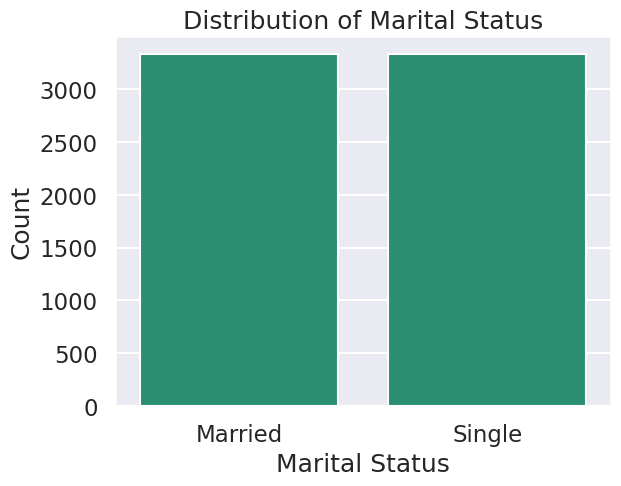

In [31]:
# Show marital status value counts and visualize them
print("Marital Status Counts:\n")
print(train["marital_status"].value_counts())

sns.countplot(data=train, x='marital_status')
plt.title("Distribution of Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.show()

Now we will convert title to gender attributes. For example, 'Mr' becomes 'M', 'Ms'/'Mrs' become 'F' and 'Mx' become 'Neutral'.

In [32]:
train["title"] = train["title"].replace({"Mr.":"M","Ms.":"F","Mrs.":"F","Mx.":"Neutral"})
train.rename(columns={"title":"gender"}, inplace=True) #Rename the column
train["gender"].unique() #To verify it's features

array(['M', 'F', 'Neutral'], dtype=object)

Gender Counts:

gender
F          3277
M          3222
Neutral     160
Name: count, dtype: int64


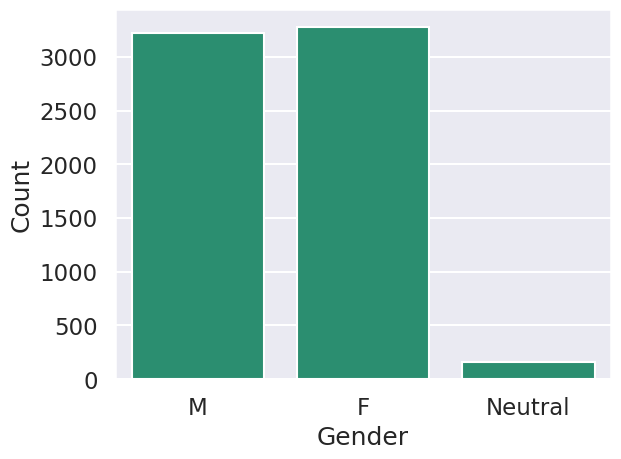

In [33]:
# Show gender value counts and visualize them
print("Gender Counts:\n")
print(train["gender"].value_counts())

sns.countplot(data=train, x='gender')
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [34]:
# Remove title from categorical feature and add gender
categorical_features.remove("title")
categorical_features.append("gender")

### Date Of Birth

Similar to title and marital column we convert date of birth to age for better usability in analysis and modeling

In [35]:
# Convert the DOB column to age and drop the date_of_birth column (assuming 01/01/2025)
train["date_of_birth"] = pd.to_datetime(train["date_of_birth"]) # First convert the train type from object to datetime
train["age"] = 2025 - train["date_of_birth"].dt.year

In [36]:
# Drop DOB column
train.drop(columns=["date_of_birth"], inplace=True)

In [37]:
train["age"].describe()

,age
count,6659.000000
mean,36.919057
std,13.092362
min,1.000000
25%,28.000000
50%,35.000000
75%,44.000000
max,115.000000


We will now remove ages below 18 and above 100 to focus on realistic adult participants, as the data involves financial behavior, wellness, and lifestyle metrics that are not relevant for children or extremely old age outliers.

In [38]:
train = train[(train["age"] >= 18) & (train["age"] <= 100)]

### City, Happiness Level & Name

So after careful examining we decided we will not be using the `name`, `city`, and `hapiness_level` columns for further analysis. These columns either contain high-cardinality values or lack meaningful patterns for modeling, so we've decided to drop them.

Name will have no use for us, city already served its purpose for mapping the countries and hapiness level only had one value which would not be usefull.

In [39]:
# Count the values for hapiness level
train["hapiness_level"].value_counts()

,count
hapiness_level,
medium,6550


In [40]:
train.drop(columns=['city', 'hapiness_level', 'name'], inplace=True)


# Remove from categorical list
for col in ['name', 'hapiness_level', 'city']:
    if col in categorical_features:
        categorical_features.remove(col)

### Education Level and Financial Wellness Index



---


Firstly, we are converting European-style decimal notation to Python-compatible float format using string replacement:

In [41]:
for col in ['education_level', 'financial_wellness_index']:
    train[col] = (
        train[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

In [42]:
train[['education_level', 'financial_wellness_index']].describe()

,education_level,financial_wellness_index
count,6319.000000,6341.000000
mean,6.273415,106.415487
std,2.921755,64.424328
min,0.000000,-0.050000
25%,4.029850,87.072600
50%,6.319900,99.773400
75%,8.512100,113.915000
max,14.244000,458.451000


Now we will handle missing values of both `education_level` and `financial_wellness_index` seperately in the best possible ways.

**Education Level**

First by using group-wise medians based on age, assuming educational level correlates with age.

Any remaining nulls are imputed using the global median.

In [43]:
grouped_median = train.groupby('age')['education_level'].median()

# Fill nulls with grouped medians
train['education_level'] = train['education_level'].fillna(
    train.groupby('age')['education_level'].transform('median')
)

# Fallback to global median for remaining NaNs
global_median = train['education_level'].median()
train['education_level'] = train['education_level'].fillna(global_median)

To enhance interpretability, we map the education levels into meaningful categories:

In [44]:
# Define the categorization function
def categorize_education(level):
    if level <= 1:
        return "No formal education"
    elif level <= 4:
        return "Primary School"
    elif level <= 8:
        return "Middle School"
    elif level <= 10:
        return "High School"
    elif level <= 12:
        return "Bachelor's"
    elif level <= 15:
        return "Master's or Higher"
    else:
        return np.nan

# Apply function and store in a new column
train['education_category'] = train['education_level'].apply(categorize_education)

# Define the correct order for categories
education_order = [
    "No formal education",
    "Primary School",
    "Middle School",
    "High School",
    "Bachelor's",
    "Master's or Higher"
]

# Convert new column to ordered categorical type
train['education_category'] = pd.Categorical(train['education_category'], categories=education_order, ordered=True)

**Financial Wellness Index**

We convert the values from string to float, and clip all the negative values to zero.

We also fill the missing values via random sampling from the existing distribution to retain realistic variance.

In [45]:
# Replace any negative values in financial_wellness_index with 0
train['financial_wellness_index'] = train['financial_wellness_index'].clip(lower=0)

# Fill missing values with random samples to preserve the distribution and avoid unusal spikes.
def random_sample_impute(series):
    missing = series.isnull()
    n_missing = missing.sum()

    sampled = series.dropna().sample(n=n_missing, replace=True, random_state=42)
    sampled.index = series[missing].index

    return series.fillna(sampled)

train['financial_wellness_index'] = random_sample_impute(train['financial_wellness_index'])

We group financial scores into three simplified tiers:

In [46]:
# Convert financial wellness index into categorical levels: Low, Medium, and High for better interpretation
def convert_to_financial_wellness_level(x):
    if x <= 70:
        return 'Low'
    elif x <= 130:
        return 'Medium'
    else:
        return 'High'

train['financial_wellness_category'] = train['financial_wellness_index'].apply(convert_to_financial_wellness_level)

In [47]:
# Verify category assignments for education and financial wellness
train[['education_level', 'education_category',
      'financial_wellness_index', 'financial_wellness_category',
      'age']].head(10)

,education_level,education_category,financial_wellness_index,financial_wellness_category,age
0,6.4833,Middle School,100.9170,Medium,25
1,4.9876,Middle School,346.8460,High,35
2,8.7202,High School,124.2740,Medium,27
3,5.6046,Middle School,100.4960,Medium,45
4,9.9730,High School,192.6670,High,47
5,5.3713,Middle School,96.6573,Medium,24
6,7.9457,Middle School,97.7436,Medium,32
7,10.1845,Bachelor's,84.9210,Medium,24
8,1.5155,Primary School,101.0500,Medium,31
9,3.4514,Primary School,96.9160,Medium,22


The following visualizations are created to support data quality checks and analysis:

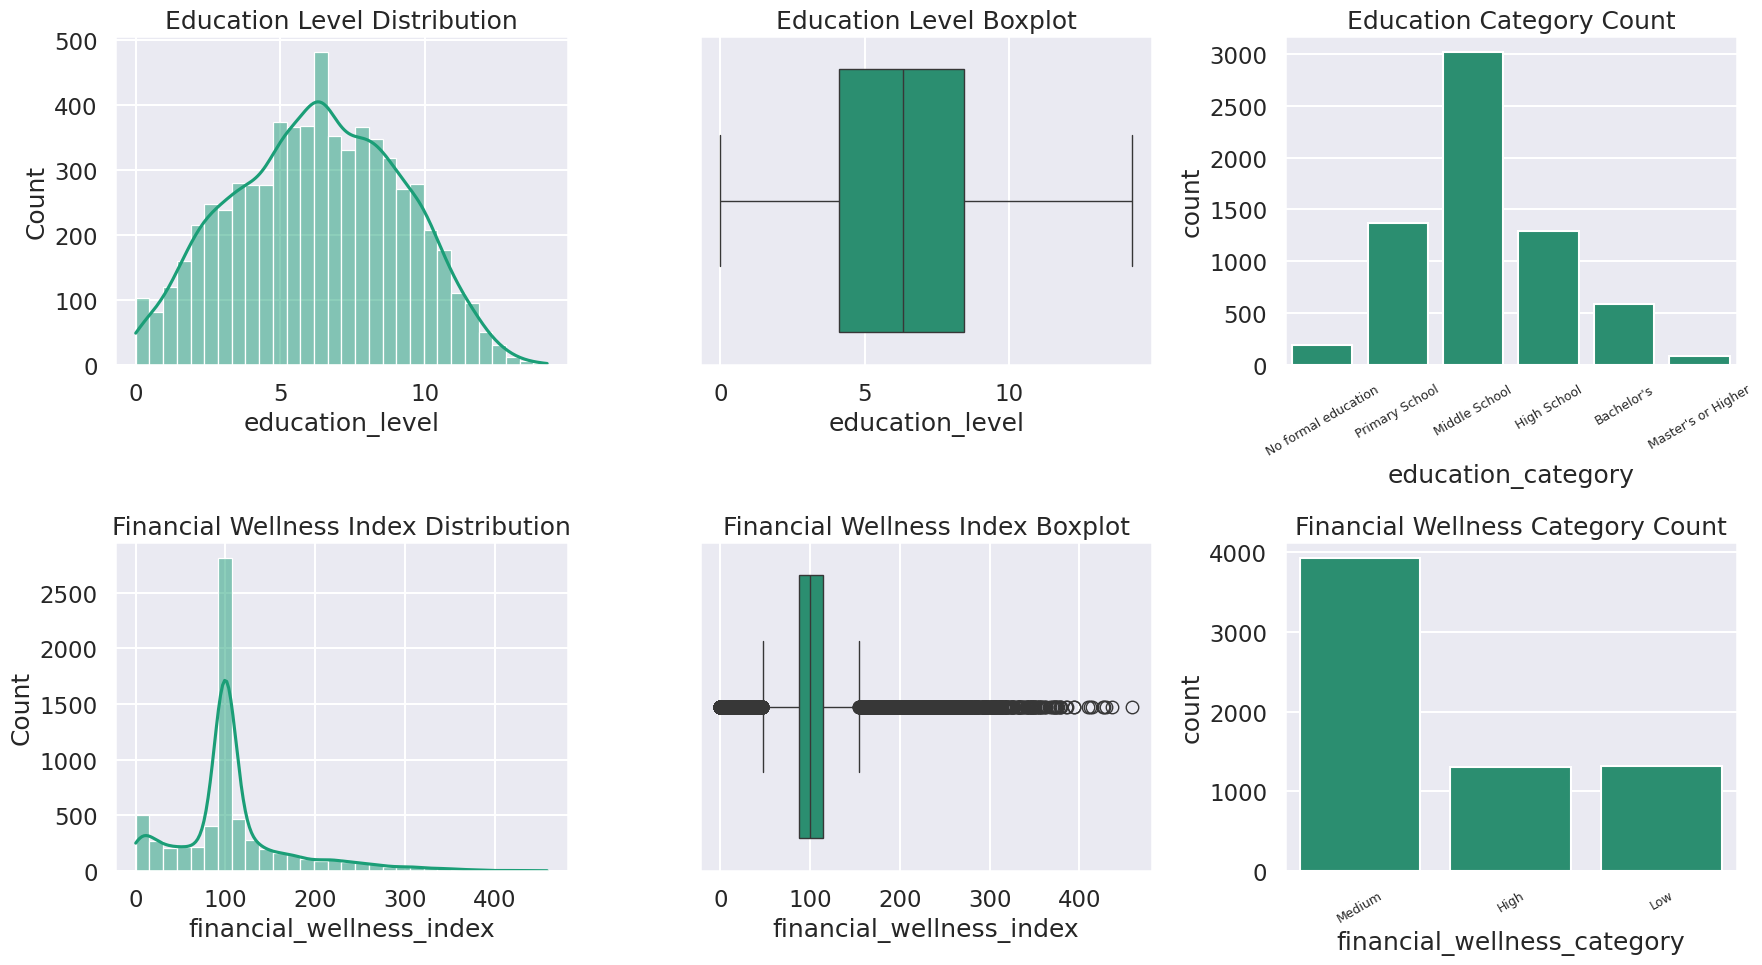

In [48]:
# Plot distribution, boxplot, and category count for both education and financial wellness.
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

sns.histplot(train['education_level'], bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Education Level Distribution')

sns.boxplot(x=train['education_level'], ax=axs[0, 1])
axs[0, 1].set_title('Education Level Boxplot')

sns.countplot(data=train, x='education_category', ax=axs[0, 2])
axs[0, 2].set_title('Education Category Count')
axs[0, 2].tick_params(axis='x', rotation=30, labelsize=9)

sns.histplot(train['financial_wellness_index'], bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Financial Wellness Index Distribution')

sns.boxplot(x=train['financial_wellness_index'], ax=axs[1, 1])
axs[1, 1].set_title('Financial Wellness Index Boxplot')

sns.countplot(data=train, x='financial_wellness_category', ax=axs[1, 2])
axs[1, 2].set_title('Financial Wellness Category Count')
axs[1, 2].tick_params(axis='x', rotation=30, labelsize=9)

plt.tight_layout()
plt.show()

**Education Level**

  * **Distribution** plot confirms a right-skewed bell shape centered around middle school to high school levels.

  * **Boxplot** shows central tendency and spread.

  * **Category Count** plot shows that most individuals fall in the “Middle School” and “Primary School” groups.

**Financial Wellness Index**

  * **Distribution** shows a right-skew with a spike around common index values, supporting the decision to categorize.

  * **Boxplot** reveals heavy-tailed outliers, another reason for categorization.

  * **Category Count** shows that the majority fall into the Medium financial wellness bracket, with smaller groups in High and Low tiers.

## Numerical Features Cleaning

In this section we will go column by column taking care of nulls, outliers, skewness and other things that might need to be worked on , along with exploratory data analysis. Also, keep in mind that whenever we use a function to scale the data we create a new column with "scaled" so we can later use it for modelling. Our goal is to normalize the data and minimize the outliers, which we will check with histplots and boxplots for each column.

In [49]:
# Create a for loop to convert every numerical feature to float
for feature in numerical_features:
    train[feature] = (
        train[feature]
        .astype(str)  # Ensure it's a string first
        .str.replace(',', '.')  # Replace commas with dots
        .astype(float)
        )

In [50]:
train[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
last_year_charity_donations,6447.0,0.385124,0.774445,0.0000,0.000000,0.01030,0.307300,5.5991
financial_wellness_index,6550.0,106.584963,64.427945,0.0000,87.191200,99.80110,114.117250,458.4510
investment_portfolio_value,6444.0,12.637204,21.896614,0.0000,3.384550,8.77190,13.307050,294.9500
social_media_influence_score,6550.0,6.111014,4.326335,0.0000,3.172800,4.41040,8.257675,42.1768
investments_risk_appetite,6349.0,4.411012,2.633447,0.0000,1.914600,4.87250,6.876600,8.6995
investments_risk_tolerance,6423.0,7.328556,3.712402,1.3937,4.802250,6.22070,8.569650,29.5132
avg_monthly_entertainment_expenses,6359.0,21.686809,17.404108,0.0000,8.181300,12.10080,38.780050,135.4200
avg_weekly_exercise_hours,6383.0,0.702925,1.187871,-5.5794,0.022650,0.10920,1.000700,8.7017
stress_management_score,6317.0,3.323779,1.126843,0.3192,2.558600,3.15640,3.984100,8.7123
eco_consciousness_score,6379.0,0.131649,0.359325,-1.4167,0.000000,0.00770,0.024300,3.2475


We will start with understanding the relationship of numerical features with each other so we can choose how to deal with them.

### Environmental Awareness Rating

In [51]:
train['environmental_awareness_rating'].describe()

,environmental_awareness_rating
count,6524.000000
mean,0.821633
std,0.636974
min,0.037600
25%,0.540700
50%,0.631000
75%,0.772650
max,7.402500


In [52]:
train['environmental_awareness_rating'].isnull().sum()

np.int64(26)

In [53]:
#Fix null values
environmental_awareness_rating_median = train['environmental_awareness_rating'].median()

train['environmental_awareness_rating'] = train['environmental_awareness_rating'].fillna(environmental_awareness_rating_median)

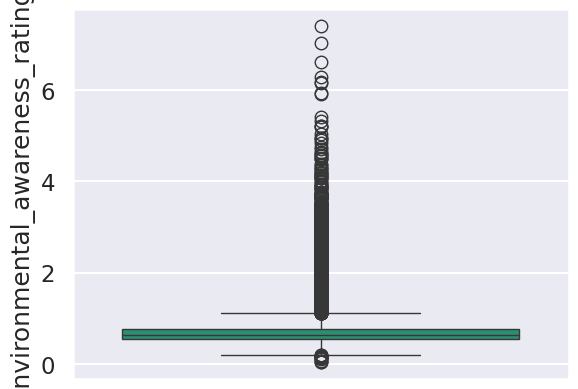

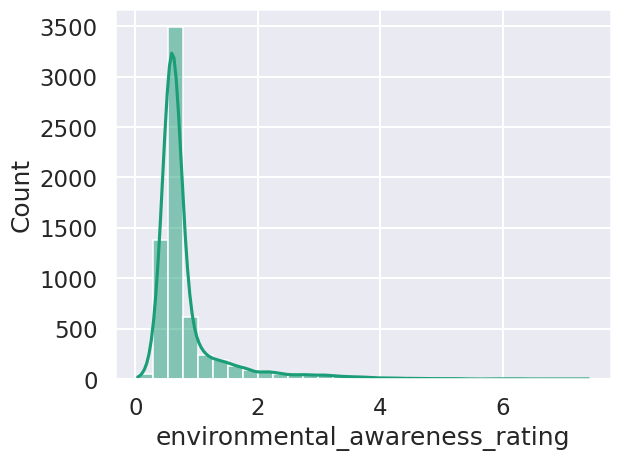

In [54]:
sns.boxplot(train['environmental_awareness_rating'])
plt.show()
sns.histplot(train['environmental_awareness_rating'], bins=30, kde=True)
plt.show()

From this histplot we noticed that it had a very long tail and that it was super skewed to the right, so from now on we decided the best approach for this type of cases was to use the log function.

In [55]:
# check how many outliers
Q1 = train['environmental_awareness_rating'].quantile(0.25)  # 25th percentile
Q3 = train['environmental_awareness_rating'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers

outliers = train[(train['environmental_awareness_rating'] < lower_bound) |
                (train['environmental_awareness_rating'] > upper_bound)]

print(outliers.count())

citizen_id                            912
avg_monthly_entertainment_expenses    882
avg_weekly_exercise_hours             883
country                               912
eco_consciousness_score               892
education_level                       912
environmental_awareness_rating        912
financial_wellness_index              912
health_consciousness_rating           882
investment_portfolio_value            901
investments_risk_appetite             879
investments_risk_tolerance            893
last_year_charity_donations           898
lifestyle                             912
marital_status                        912
social_media_influence_score          912
stress_management_score               885
gender                                912
well_being_level                      899
continent                             912
age                                   912
education_category                    912
financial_wellness_category           912
dtype: int64


In [56]:
#Log transform to scale (log1p handles 0 safely)
train['environmental_awareness_rating_scaled'] = np.log1p(train['environmental_awareness_rating'])

We decided to use the log-transform to reduce right skew and handle extreme values because log1p handles 0s safely

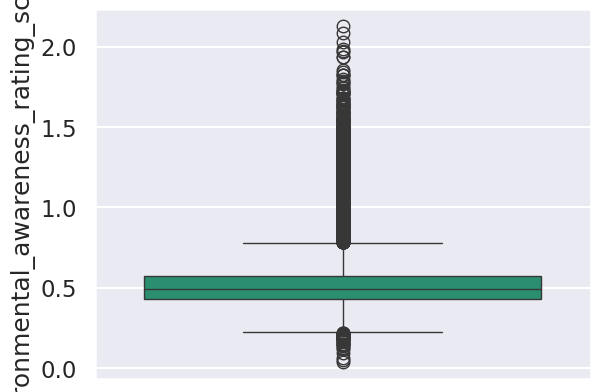

In [57]:
#boxplot
sns.boxplot(train['environmental_awareness_rating_scaled'])
plt.show()

In [58]:
#Scale using RobustScaler
env_scaler = RobustScaler()
train['environmental_awareness_rating_scaled'] = env_scaler.fit_transform(train[['environmental_awareness_rating_scaled']])

Applied RobustScaler to reduce influence of outliers while preserving data structure

In [59]:
#check how many above 10
sum(train['environmental_awareness_rating_scaled'] > 10)
#drop them
train = train[train['environmental_awareness_rating_scaled'] <= 10]

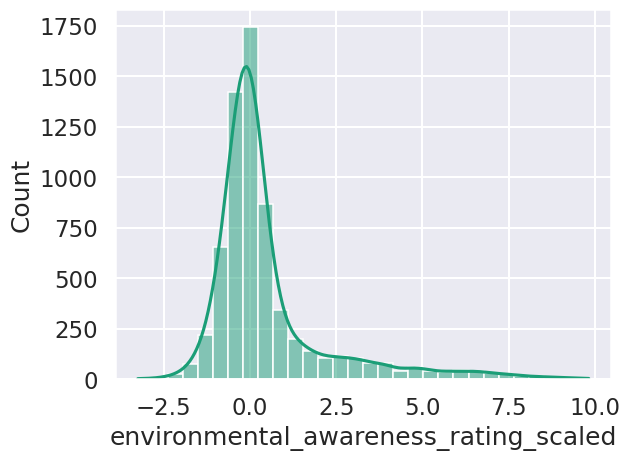

In [60]:
sns.histplot(train['environmental_awareness_rating_scaled'], bins=30, kde=True)
plt.show()

### Health Consciousness Rating

In [61]:
train['health_consciousness_rating'].isnull().sum()

np.int64(198)

In [62]:
#Fill nulls with grouped medians
health_consciousness_rating_median = train.groupby('well_being_level')['health_consciousness_rating'].transform('median')

train['health_consciousness_rating'] = train['health_consciousness_rating'].fillna(health_consciousness_rating_median)

#Fallback to global median for remaining NaNs
health_consciousness_rating_global_median = train['health_consciousness_rating'].median()
train['health_consciousness_rating'] = train['health_consciousness_rating'].fillna(health_consciousness_rating_global_median)


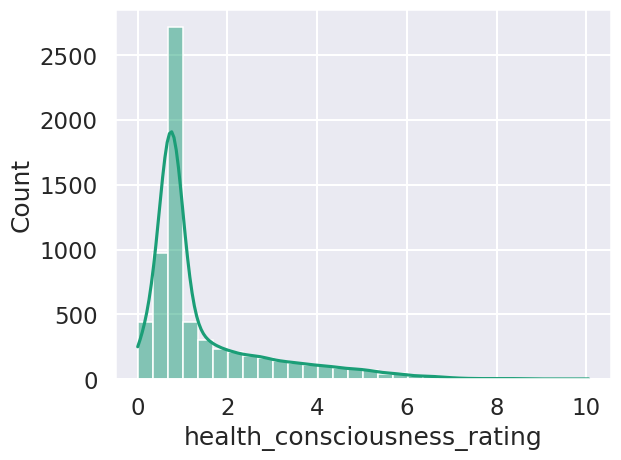

In [63]:
#histplot
sns.histplot(train['health_consciousness_rating'], bins=30, kde=True)
plt.show()

In [64]:
#Log transform (log1p handles 0 safely)
train['health_consciousness_rating_scaled'] = np.log1p(train['health_consciousness_rating'])

In [65]:
#Scale using RobustScaler
health_scaler = RobustScaler()
train['health_consciousness_rating_scaled'] = health_scaler.fit_transform(train[['health_consciousness_rating_scaled']])

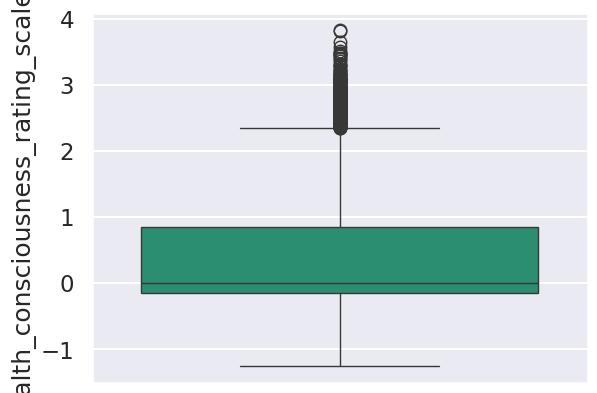

In [66]:
sns.boxplot(train['health_consciousness_rating_scaled'])
plt.show()

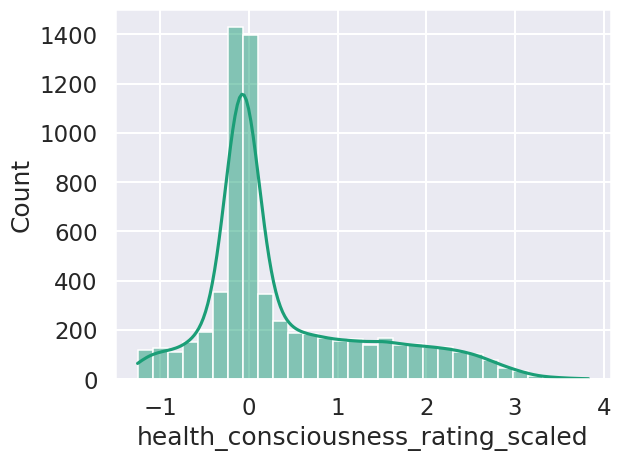

In [67]:
#histplot
sns.histplot(train['health_consciousness_rating_scaled'], bins=30, kde=True)
plt.show()

### Avg Monthly Entertainment Expenses

In [68]:
train['avg_monthly_entertainment_expenses'].describe()

,avg_monthly_entertainment_expenses
count,6352.000000
mean,21.694678
std,17.406917
min,0.000000
25%,8.182250
50%,12.112450
75%,38.782600
max,135.420000


MISSING VALUES

In [69]:
#check for missing values
train['avg_monthly_entertainment_expenses'].isnull().sum()

np.int64(190)

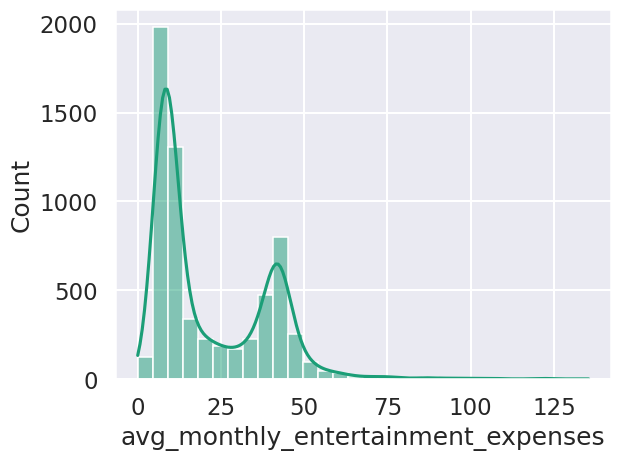

In [70]:
#histplot
sns.histplot(train['avg_monthly_entertainment_expenses'], bins=30, kde=True)
plt.show()

In [71]:
#Fill nulls with grouped medians
avg_monthly_entertainment_expenses_median = train.groupby('stress_management_score')['avg_monthly_entertainment_expenses'].transform('median')

train['avg_monthly_entertainment_expenses'] = train['avg_monthly_entertainment_expenses'].fillna(avg_monthly_entertainment_expenses_median)

#Fallback to global median for remaining NaNs
avg_monthly_entertainment_expenses_global_median = train['avg_monthly_entertainment_expenses'].median()
train['avg_monthly_entertainment_expenses'] = train['avg_monthly_entertainment_expenses'].fillna(avg_monthly_entertainment_expenses_global_median)

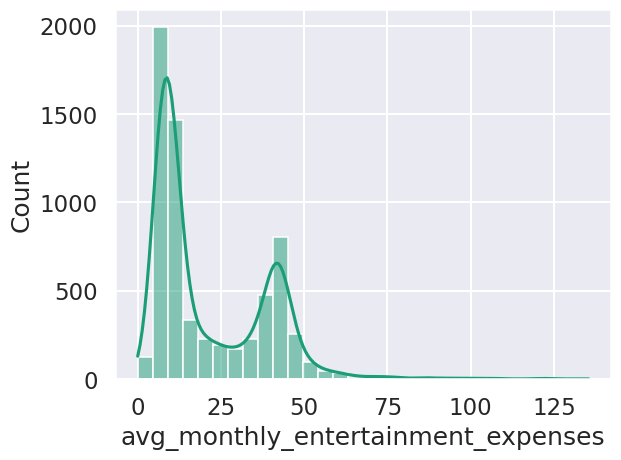

In [72]:
#histplot
sns.histplot(train['avg_monthly_entertainment_expenses'], bins=30, kde=True)
plt.show()

In [73]:
#check for outliers
train['avg_monthly_entertainment_expenses'].describe()

,avg_monthly_entertainment_expenses
count,6542.000000
mean,21.464457
std,17.250401
min,0.000000
25%,8.244650
50%,12.115800
75%,38.324600
max,135.420000


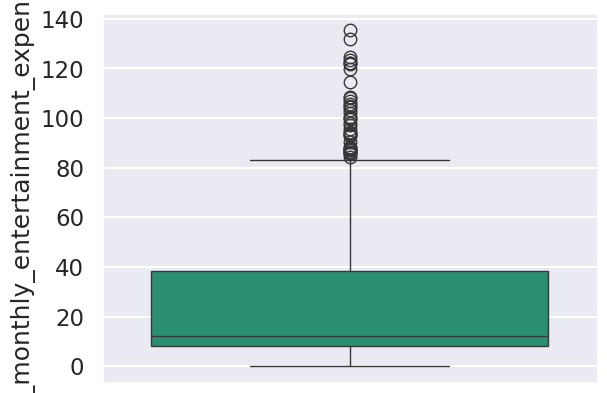

In [74]:
#boxplot
sns.boxplot(train['avg_monthly_entertainment_expenses'])
plt.show()

In [75]:
Q1 = train['avg_monthly_entertainment_expenses'].quantile(0.25)  # 25th percentile
Q3 = train['avg_monthly_entertainment_expenses'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = train[(train['avg_monthly_entertainment_expenses'] < lower_bound) |
                (train['avg_monthly_entertainment_expenses'] > upper_bound)]

print(outliers.count())

citizen_id                               40
avg_monthly_entertainment_expenses       40
avg_weekly_exercise_hours                40
country                                  40
eco_consciousness_score                  38
education_level                          40
environmental_awareness_rating           40
financial_wellness_index                 40
health_consciousness_rating              40
investment_portfolio_value               40
investments_risk_appetite                38
investments_risk_tolerance               39
last_year_charity_donations              39
lifestyle                                40
marital_status                           40
social_media_influence_score             40
stress_management_score                  38
gender                                   40
well_being_level                         37
continent                                40
age                                      40
education_category                       40
financial_wellness_category     

In [76]:
train['avg_monthly_entertainment_expenses'] = train['avg_monthly_entertainment_expenses'].clip(lower_bound, upper_bound)

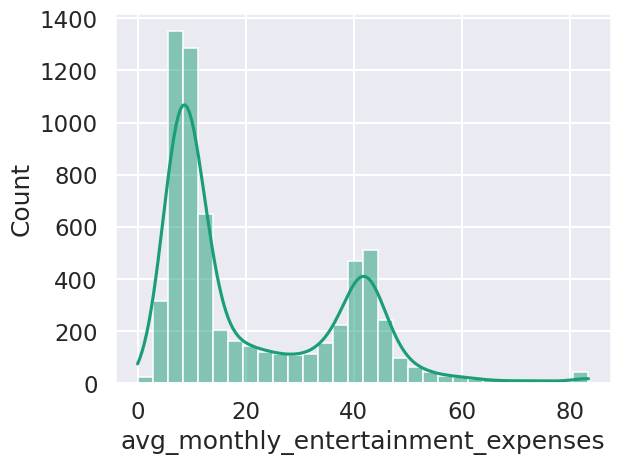

In [77]:
#histplot
sns.histplot(train['avg_monthly_entertainment_expenses'], bins=30, kde=True)
plt.show()

### Avg Weekly Exercise Hours

In [78]:
# Describe
train['avg_weekly_exercise_hours'].describe()

,avg_weekly_exercise_hours
count,6375.000000
mean,0.703049
std,1.188067
min,-5.579400
25%,0.022650
50%,0.109200
75%,1.001150
max,8.701700


In [79]:
#check nulls
train['avg_weekly_exercise_hours'].isnull().sum()

np.int64(167)

In [80]:
#Fill nulls with median value (best for skewed data)
avg_weekly_exercise_hours_median = train['avg_weekly_exercise_hours'].median()

train['avg_weekly_exercise_hours'] = train['avg_weekly_exercise_hours'].fillna(avg_weekly_exercise_hours_median)

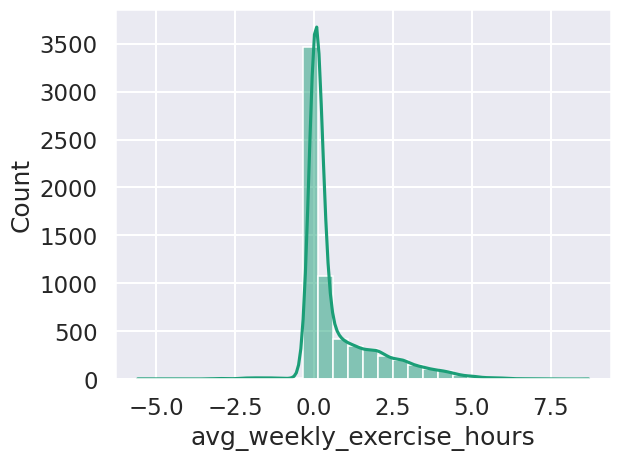

In [81]:
sns.histplot(train['avg_weekly_exercise_hours'], bins=30, kde=True)
plt.show()

We notice that we have negative hours for a varaible that shoult had negative values, so we decide do cap the lower bound to 0 since its the minimal possible value.

In [82]:
#lower bound to 0
train['avg_weekly_exercise_hours'] = train['avg_weekly_exercise_hours'].clip(lower=0)

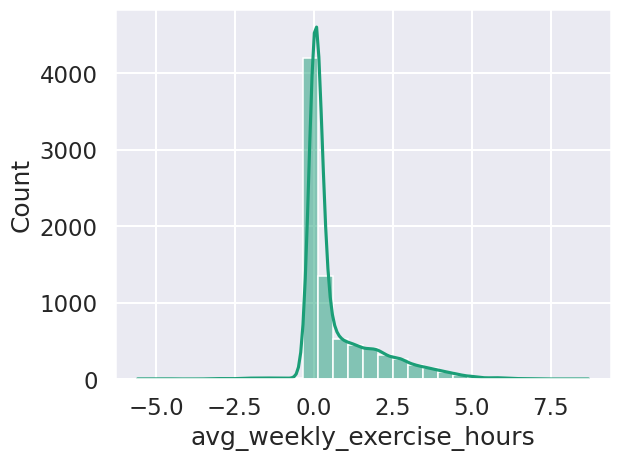

In [83]:
sns.histplot(data['avg_weekly_exercise_hours'], bins=30, kde=True)
plt.show()

In [84]:
Q1 = train['avg_weekly_exercise_hours'].quantile(0.25)  # 25th percentile
Q3 = train['avg_weekly_exercise_hours'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = train[(train['avg_weekly_exercise_hours'] < lower_bound) |
                (train['avg_weekly_exercise_hours'] > upper_bound)]

print(outliers.count())
print(upper_bound)
print(lower_bound)

citizen_id                               703
avg_monthly_entertainment_expenses       703
avg_weekly_exercise_hours                703
country                                  703
eco_consciousness_score                  685
education_level                          703
environmental_awareness_rating           703
financial_wellness_index                 703
health_consciousness_rating              703
investment_portfolio_value               690
investments_risk_appetite                682
investments_risk_tolerance               690
last_year_charity_donations              693
lifestyle                                703
marital_status                           703
social_media_influence_score             703
stress_management_score                  680
gender                                   703
well_being_level                         694
continent                                703
age                                      703
education_category                       703
financial_

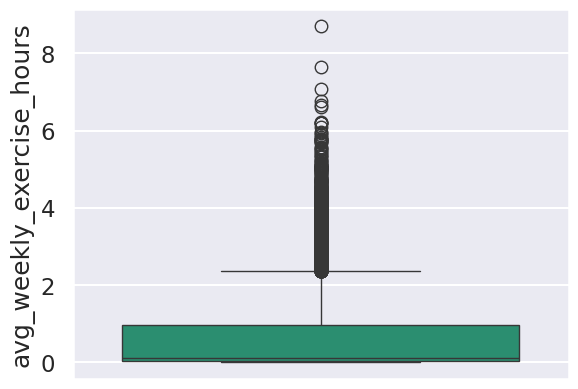

In [85]:
sns.boxplot(train['avg_weekly_exercise_hours'])
plt.show()

In [86]:
# Log transformation (add 1 to handle zeros)
train['avg_weekly_exercise_hours_scaled'] = np.log1p(train['avg_weekly_exercise_hours'])

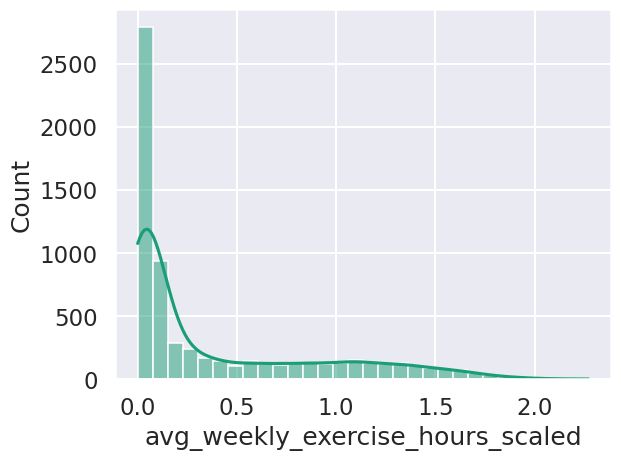

In [87]:
sns.histplot(train['avg_weekly_exercise_hours_scaled'], bins=30, kde=True)
plt.show()

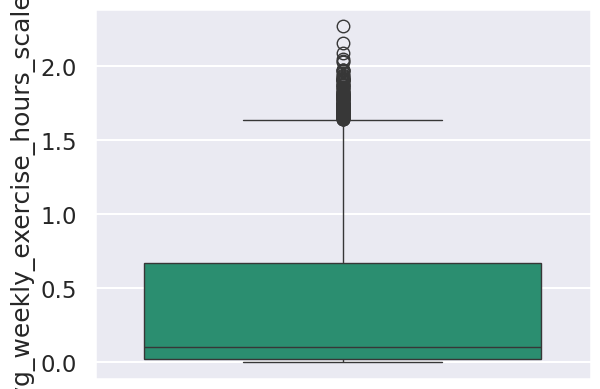

In [88]:
sns.boxplot(train['avg_weekly_exercise_hours_scaled'])
plt.show()

In [89]:
#how many above 2
sum(train['avg_weekly_exercise_hours_scaled'] > 2)
#drop them
train = train[train['avg_weekly_exercise_hours_scaled'] <= 2]

### Stress Management Score

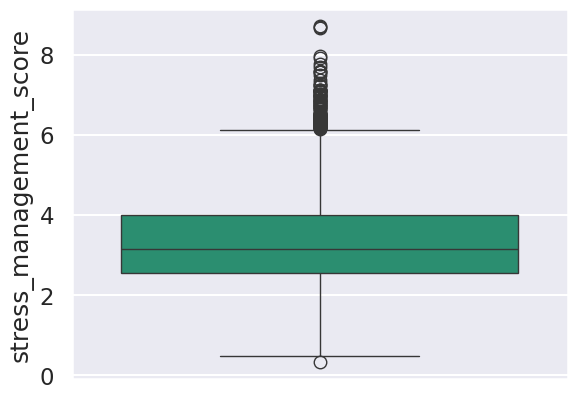

In [90]:
sns.boxplot(train['stress_management_score'])
plt.show()

In [91]:
train["stress_management_score"].isnull().sum()

np.int64(233)

The highest correlations we had on all the columns was 0.75 between stress management score and well being level, so we will use it to fill the nulls

In [92]:
#highest correlation is with well being level, 0.75
#Fill nulls with grouped medians
stress_management_score_median = train.groupby('well_being_level')['stress_management_score'].transform('median')
train['stress_management_score'] = train['stress_management_score'].fillna(stress_management_score_median)

#Fallback to global median for remaining NaNs
stress_management_score_median_global_median = train['stress_management_score'].median()
train['stress_management_score'] = train['stress_management_score'].fillna(global_median)

In [93]:
train["stress_management_score"].describe()

,stress_management_score
count,6536.000000
mean,3.418092
std,1.224663
min,0.319200
25%,2.585400
50%,3.199000
75%,4.093375
max,8.712300


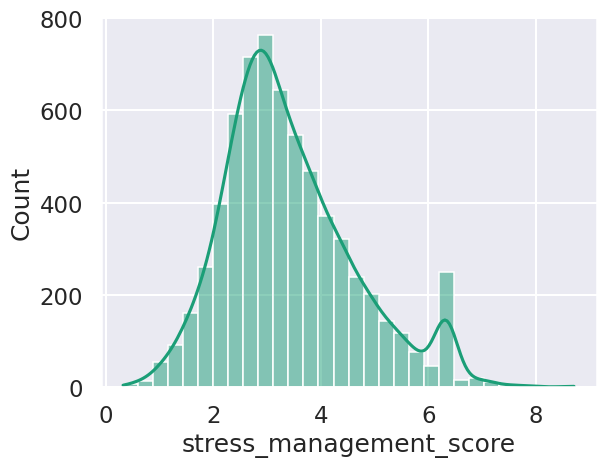

In [94]:
sns.histplot(train['stress_management_score'], bins=30, kde=True)
plt.show()

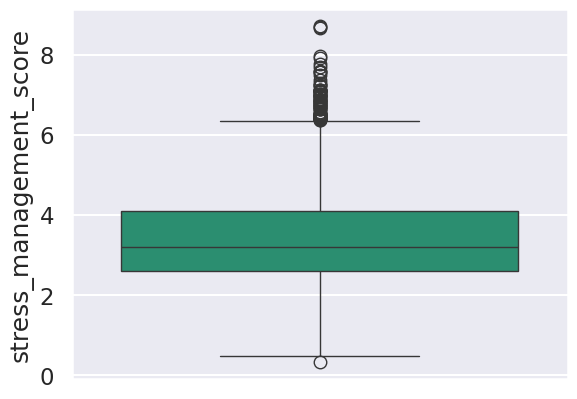

In [95]:
sns.boxplot(train['stress_management_score'])
plt.show()

In [96]:
Q1 = train['stress_management_score'].quantile(0.25)  # 25th percentile
Q3 = train['stress_management_score'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = train[(train['stress_management_score'] < lower_bound) |
                (train['stress_management_score'] > upper_bound)]

#count how many values above 8 and below the lower bound (0.43389999) and drop them
train= train[train['stress_management_score'] <= 8]
train= train[train['stress_management_score'] >= 0.43389999]


### Eco Consciousness Score (Dropped)

In [97]:
train['eco_consciousness_score'].isnull().sum()

np.int64(169)

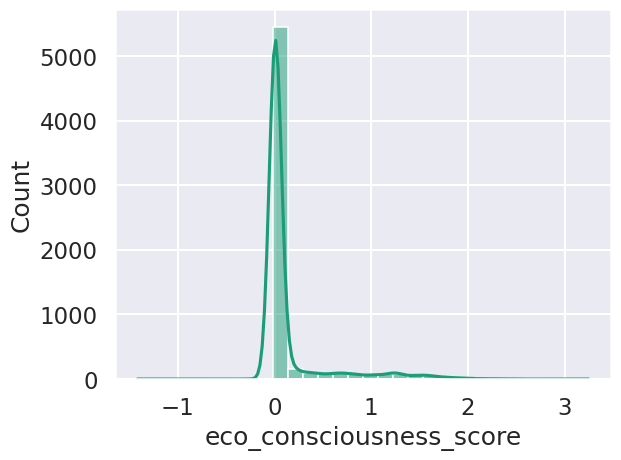

In [98]:
sns.histplot(train['eco_consciousness_score'], bins=30, kde=True)
plt.show()

In [99]:
#describe
train['eco_consciousness_score'].describe()

,eco_consciousness_score
count,6363.000000
mean,0.131682
std,0.359124
min,-1.416700
25%,0.000000
50%,0.007700
75%,0.024300
max,3.247500


Remove the values below zero.

In [100]:
#lower bound to 0
train['eco_consciousness_score'] = train['eco_consciousness_score'].clip(lower=0)
#Log transform in-place (log1p handles 0 safely)
train['eco_consciousness_score'] = np.log1p(train['eco_consciousness_score'])

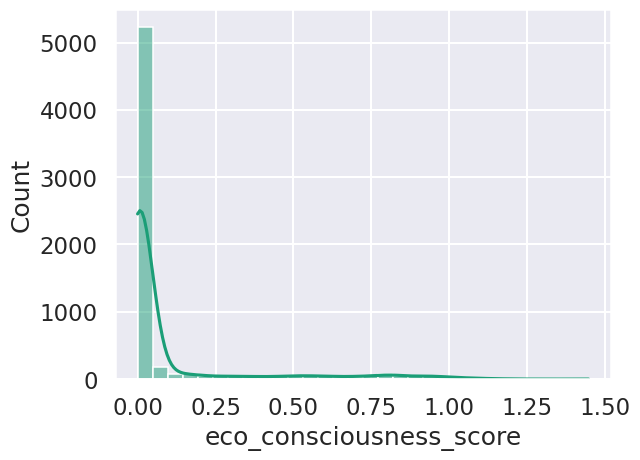

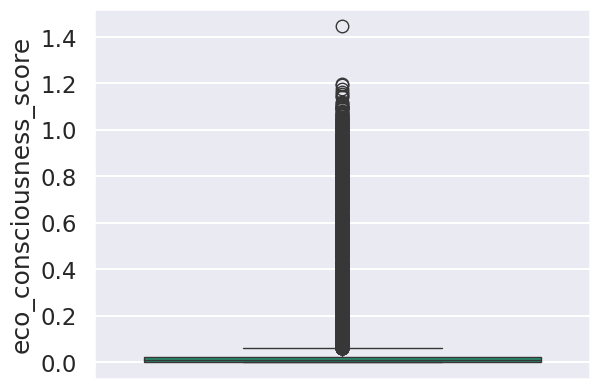

In [101]:
sns.histplot(train['eco_consciousness_score'], bins=30, kde=True)
plt.show()
sns.boxplot(train['eco_consciousness_score'])
plt.show()

In [102]:
Q1 = train['eco_consciousness_score'].quantile(0.25)  # 25th percentile
Q3 = train['eco_consciousness_score'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = train[(train['eco_consciousness_score'] < lower_bound) |
                (train['eco_consciousness_score'] > upper_bound)]

print(outliers.count())

citizen_id                               1074
avg_monthly_entertainment_expenses       1074
avg_weekly_exercise_hours                1074
country                                  1074
eco_consciousness_score                  1074
education_level                          1074
environmental_awareness_rating           1074
financial_wellness_index                 1074
health_consciousness_rating              1074
investment_portfolio_value               1062
investments_risk_appetite                1032
investments_risk_tolerance               1047
last_year_charity_donations              1055
lifestyle                                1074
marital_status                           1074
social_media_influence_score             1074
stress_management_score                  1074
gender                                   1074
well_being_level                         1048
continent                                1074
age                                      1074
education_category                

In [103]:
# Clip only beyond a wider range (e.g. 2.5 * IQR instead of 1.5)
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR
train['eco_consciousness_score'] = train['eco_consciousness_score'].clip(lower_bound, upper_bound)

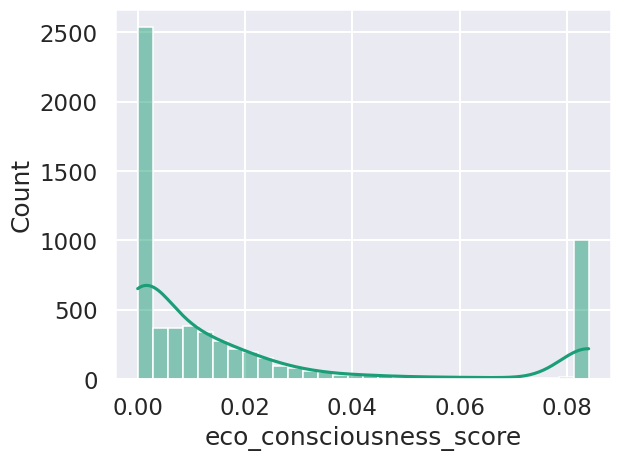

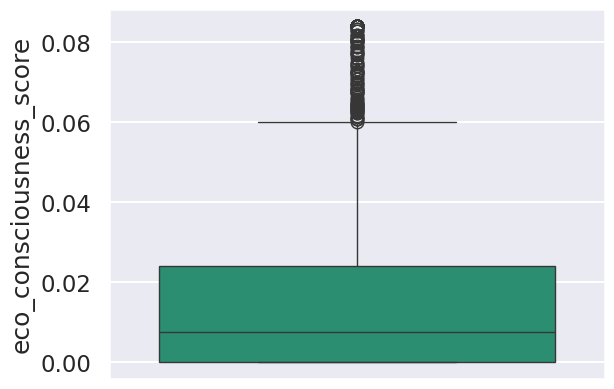

In [104]:
sns.histplot(train['eco_consciousness_score'], bins=30, kde=True)
plt.show()
sns.boxplot(train['eco_consciousness_score'])
plt.show()

In [105]:
#drop column
train.drop('eco_consciousness_score', axis=1, inplace=True)
numerical_features.remove('eco_consciousness_score')

After looking at the data and doing some cleaning, we decided to drop the `eco_consciousness_score` column. Most of the values were close to zero, and some were even negative, which didn’t make sense. It also didn’t have a strong connection with other features, so we felt it wasn’t useful for our analysis.

### Well Being Level

In [106]:
train["well_being_level"].isnull().sum()

np.int64(97)

In [107]:
train["well_being_level"].describe()

,well_being_level
count,6435.000000
mean,4.776822
std,1.946963
min,1.153900
25%,3.421350
50%,4.329700
75%,5.636500
max,14.114300


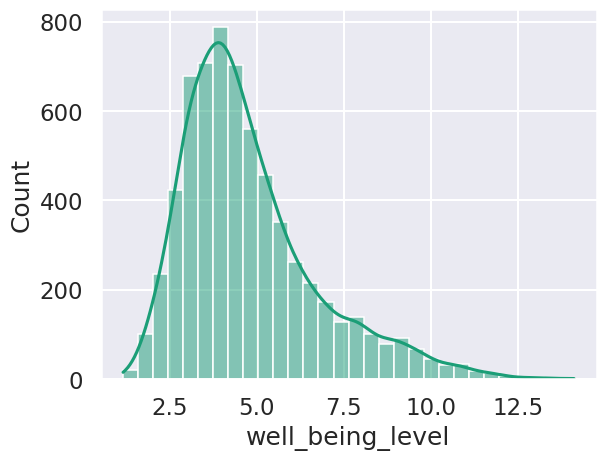

In [108]:
sns.histplot(train['well_being_level'], bins=30, kde=True)
plt.show()

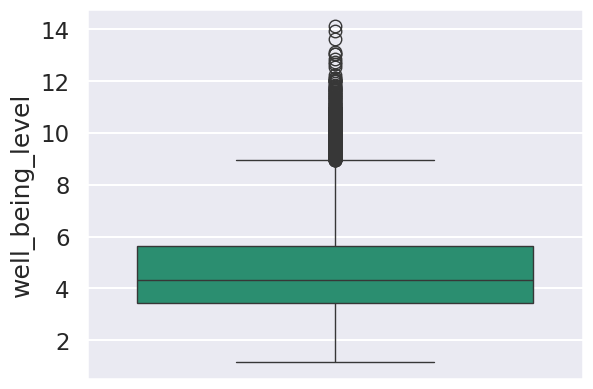

In [109]:
sns.boxplot(train['well_being_level'])
plt.show()

We decided to use the KNN imputer to fill in the missing values for `well_being_level` using `stress_management_score` and `health_consciousness_rating`, since these features are related (0.75 and 0.67) and can help estimate the missing values more accurately.

In [110]:
#use the knn inputer to fill the missing values with the stress_managemnet_score and health_consciousness_rating
cols = ['well_being_level', 'stress_management_score', 'health_consciousness_rating']

In [111]:
#define and fit the model
imputer = KNNImputer(n_neighbors=5).fit(train[cols])

In [112]:
#transform
imputed_array = imputer.transform(train[cols])

In [113]:
#Update only 'well_being_level' (first column of result)
train['well_being_level'] = imputed_array[:, 0]

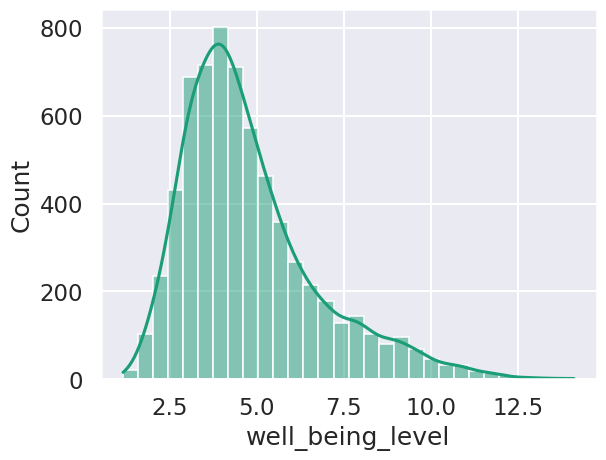

In [114]:
sns.histplot(train['well_being_level'], bins=30, kde=True)
plt.show()

In [115]:
train['well_being_level'].describe()

,well_being_level
count,6532.000000
mean,4.779576
std,1.948716
min,1.153900
25%,3.422775
50%,4.334200
75%,5.643375
max,14.114300


In [116]:
# Calculate IQR
Q1 = train['well_being_level'].quantile(0.25)
Q3 = train['well_being_level'].quantile(0.75)
IQR = Q3 - Q1

# Define wider bounds (2.5x IQR)
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

# Clip the values
train['well_being_level'] = train['well_being_level'].clip(lower_bound, upper_bound)

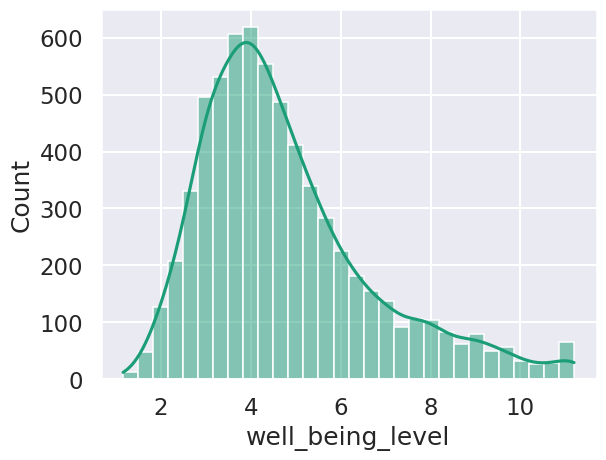

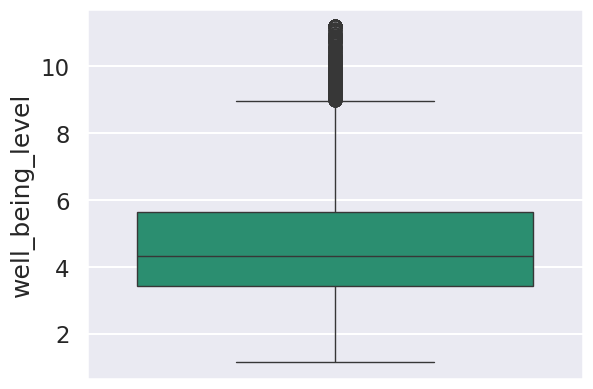

In [117]:
sns.histplot(train['well_being_level'], bins=30, kde=True)
plt.show()
sns.boxplot(train['well_being_level'])
plt.show()

### Last Year Charity Donations (Dropped)

In [118]:
train["last_year_charity_donations"].isnull().sum()

np.int64(103)

In [119]:
train["last_year_charity_donations"].describe()

,last_year_charity_donations
count,6429.000000
mean,0.383678
std,0.771853
min,0.000000
25%,0.000000
50%,0.010300
75%,0.304900
max,5.599100


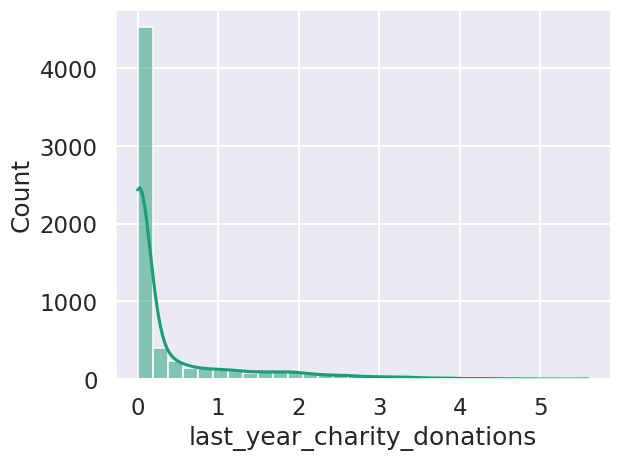

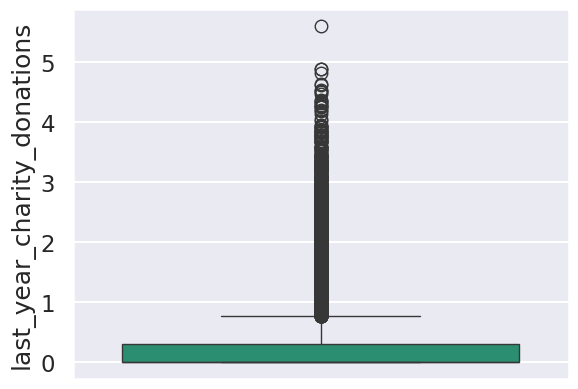

In [120]:
sns.histplot(train['last_year_charity_donations'], bins=30, kde=True)
plt.show()
sns.boxplot(train['last_year_charity_donations'])
plt.show()

In [121]:
train['last_year_charity_donations'] = train.groupby('country')['last_year_charity_donations'].transform(
    lambda x: x.fillna(x.median())
)

In [122]:
last_year_charity_donations_median = train.groupby('country')['last_year_charity_donations'].transform('median')
train['last_year_charity_donations'] = train['last_year_charity_donations'].fillna(last_year_charity_donations_median)

#Fallback to global median for remaining NaNs
last_year_charity_donations_global_median = train['last_year_charity_donations'].median()
train['last_year_charity_donations'] = train['last_year_charity_donations'].fillna(last_year_charity_donations_global_median)

In [123]:
Q1 = train['last_year_charity_donations'].quantile(0.25)  # 25th percentile
Q3 = train['last_year_charity_donations'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = train[(train['last_year_charity_donations'] < lower_bound) |
                (train['last_year_charity_donations'] > upper_bound)]

print(outliers.count())

citizen_id                               1132
avg_monthly_entertainment_expenses       1132
avg_weekly_exercise_hours                1132
country                                  1132
education_level                          1132
environmental_awareness_rating           1132
financial_wellness_index                 1132
health_consciousness_rating              1132
investment_portfolio_value               1114
investments_risk_appetite                1098
investments_risk_tolerance               1114
last_year_charity_donations              1132
lifestyle                                1132
marital_status                           1132
social_media_influence_score             1132
stress_management_score                  1132
gender                                   1132
well_being_level                         1132
continent                                1132
age                                      1132
education_category                       1132
financial_wellness_category       

In [124]:
#multiply all the rows by 1000 to check real values (it was in thousands)
train['last_year_charity_donations'] = train['last_year_charity_donations'] * 1000

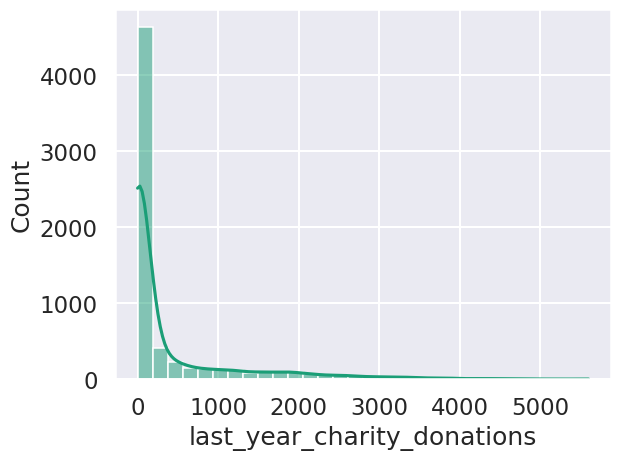

In [125]:
sns.histplot(train['last_year_charity_donations'], bins=30, kde=True)
plt.show()

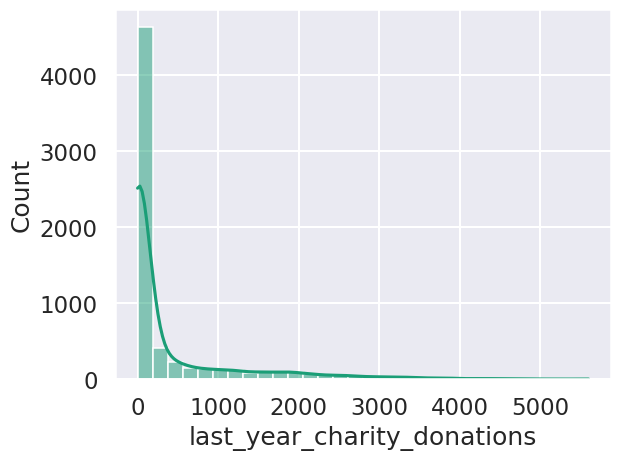

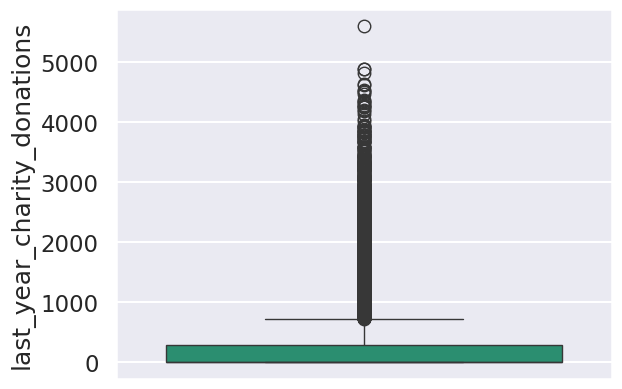

In [126]:
sns.histplot(train['last_year_charity_donations'], bins=30, kde=True)
plt.show()
sns.boxplot(train['last_year_charity_donations'])
plt.show()

In [127]:
#drop the column
train.drop('last_year_charity_donations', axis=1, inplace=True)
numerical_features.remove('last_year_charity_donations')

Like the eco consciousness score, we decided that this column is also not useful for our analysis as it was very skewed, so we decided to drop it.

### Investment Portfolio Value

In [128]:
train["investment_portfolio_value"].isnull().sum()

np.int64(106)

In [129]:
train["investment_portfolio_value"].describe()

,investment_portfolio_value
count,6426.00000
mean,12.64740
std,21.92336
min,0.00000
25%,3.37965
50%,8.77040
75%,13.30575
max,294.95000


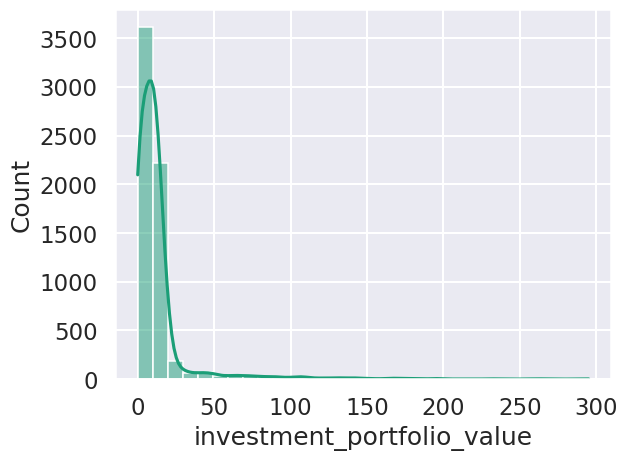

In [130]:
sns.histplot(train['investment_portfolio_value'], bins=30, kde=True)
plt.show()

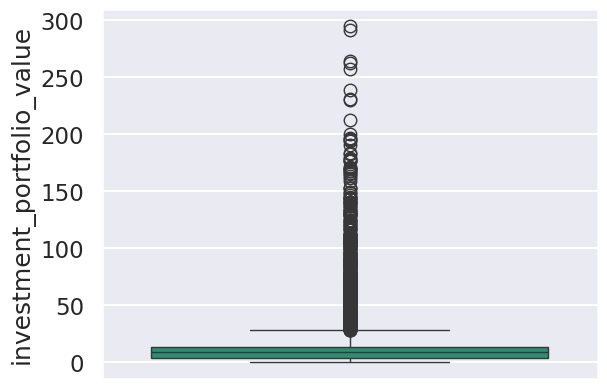

In [131]:
sns.boxplot(train['investment_portfolio_value'])
plt.show()

In [132]:
investment_portfolio_value_median = train.groupby('country')['investment_portfolio_value'].transform('median')
train['investment_portfolio_value'] = train['investment_portfolio_value'].fillna(investment_portfolio_value_median)

#Fallback to global median for remaining NaNs
investment_portfolio_value_global_median = train['investment_portfolio_value'].median()
train['investment_portfolio_value'] = train['investment_portfolio_value'].fillna(investment_portfolio_value_global_median)

In [133]:
upper_bound = train['investment_portfolio_value'].quantile(0.995)  # 99.5th percentile

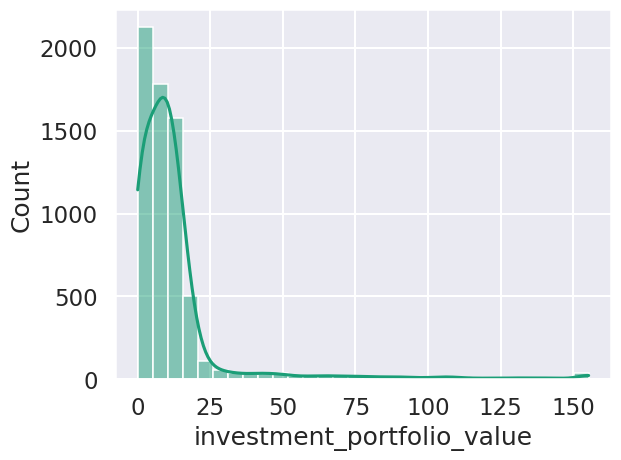

In [134]:
train['investment_portfolio_value'] = train['investment_portfolio_value'].clip(upper=upper_bound)
sns.histplot(train['investment_portfolio_value'], bins=30, kde=True)
plt.show()

In [135]:
train['investment_portfolio_value_scaled'] = np.log1p(train['investment_portfolio_value'])

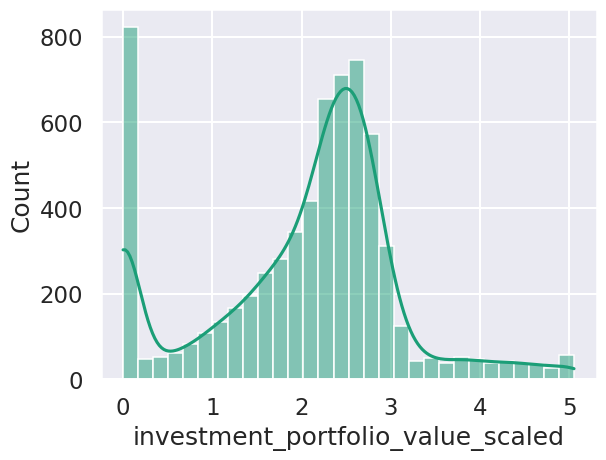

In [136]:
sns.histplot(train['investment_portfolio_value_scaled'], bins=30, kde=True)
plt.show()

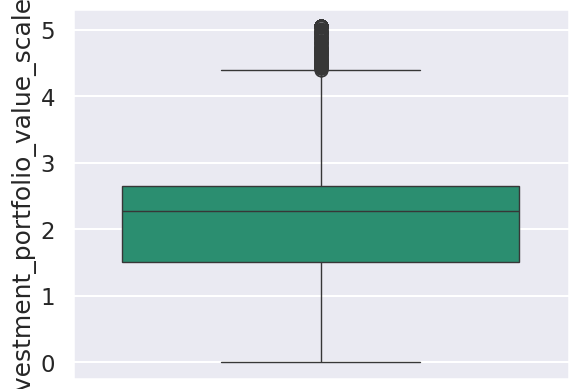

In [137]:
sns.boxplot(train['investment_portfolio_value_scaled'])
plt.show()

### Social Media Influence Score

In [138]:
train["social_media_influence_score"].isnull().sum()

np.int64(0)

In [139]:
train["social_media_influence_score"].describe()

,social_media_influence_score
count,6532.000000
mean,6.113361
std,4.327808
min,0.003500
25%,3.173775
50%,4.410550
75%,8.260350
max,42.176800


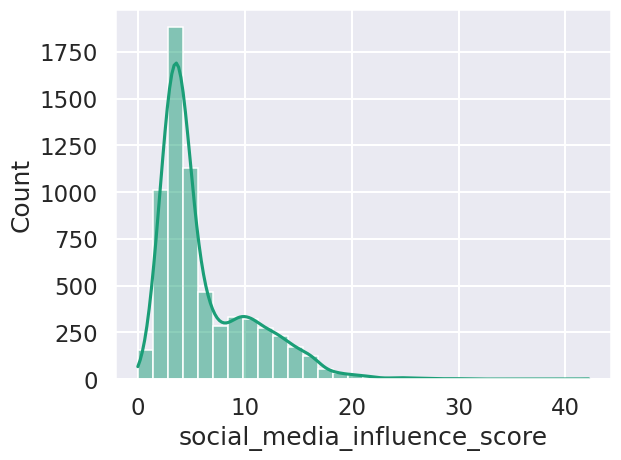

In [140]:
sns.histplot(train['social_media_influence_score'], bins=30, kde=True)
plt.show()

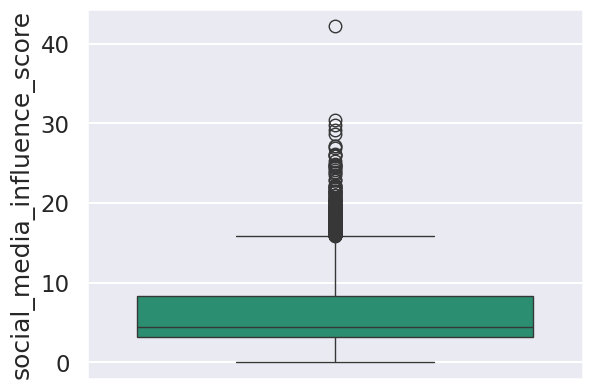

In [141]:
sns.boxplot(train['social_media_influence_score'])
plt.show()

In [142]:
#drop the highest value
train = train[train['social_media_influence_score'] != train['social_media_influence_score'].max()]

In [143]:
Q1 = train['social_media_influence_score'].quantile(0.25)  # 25th percentile
Q3 = train['social_media_influence_score'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = train[(train['social_media_influence_score'] < lower_bound) |
                (train['social_media_influence_score'] > upper_bound)]

print(outliers.count())
print(upper_bound)
print(lower_bound)

citizen_id                               239
avg_monthly_entertainment_expenses       239
avg_weekly_exercise_hours                239
country                                  239
education_level                          239
environmental_awareness_rating           239
financial_wellness_index                 239
health_consciousness_rating              239
investment_portfolio_value               239
investments_risk_appetite                233
investments_risk_tolerance               233
lifestyle                                239
marital_status                           239
social_media_influence_score             239
stress_management_score                  239
gender                                   239
well_being_level                         239
continent                                239
age                                      239
education_category                       239
financial_wellness_category              239
environmental_awareness_rating_scaled    239
health_con

In [144]:
#using the log scaler
train['social_media_influence_score_scaled'] = np.log1p(train['social_media_influence_score'])

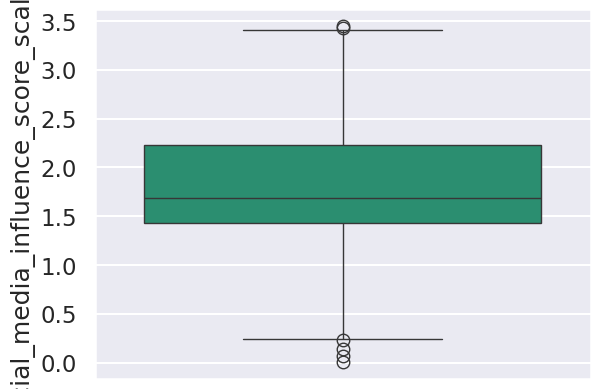

In [145]:
sns.boxplot(train['social_media_influence_score_scaled'])
plt.show()

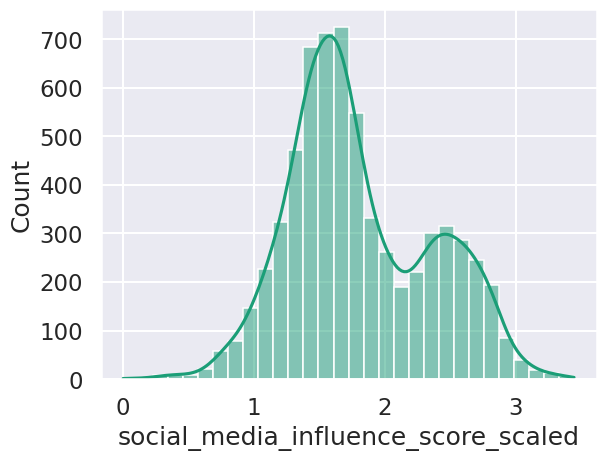

In [146]:
sns.histplot(train['social_media_influence_score_scaled'], bins=30, kde=True)
plt.show()

### Investment Risk Appetite

In [147]:
train["investments_risk_appetite"].isnull().sum()

np.int64(201)

In [148]:
train["investments_risk_appetite"].describe()

,investments_risk_appetite
count,6330.000000
mean,4.412179
std,2.632987
min,0.000000
25%,1.916775
50%,4.874800
75%,6.876450
max,8.699500


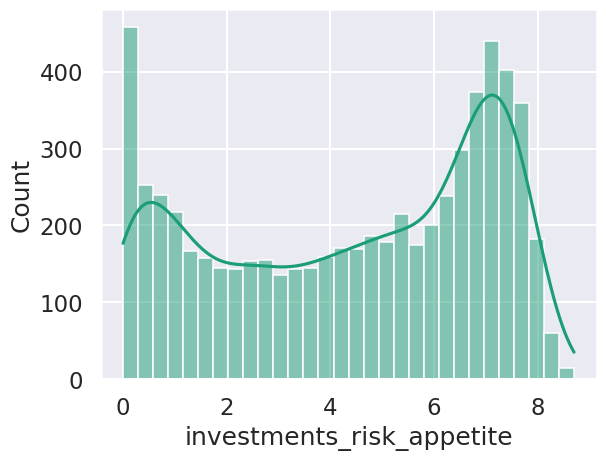

In [149]:
sns.histplot(train['investments_risk_appetite'], bins=30, kde=True)
plt.show()

In [150]:
#Fill nulls with grouped medians from the column with highest correlation

investments_risk_appetite_median = train.groupby('investments_risk_tolerance')['investments_risk_appetite'].transform('median')
train['investments_risk_appetite'] = train['investments_risk_appetite'].fillna(investments_risk_appetite_median)

#Fallback to global median for remaining NaNs
investments_risk_appetite_global_median = train['investments_risk_appetite'].median()
train['investments_risk_appetite'] = train['investments_risk_appetite'].fillna(investments_risk_appetite_global_median)

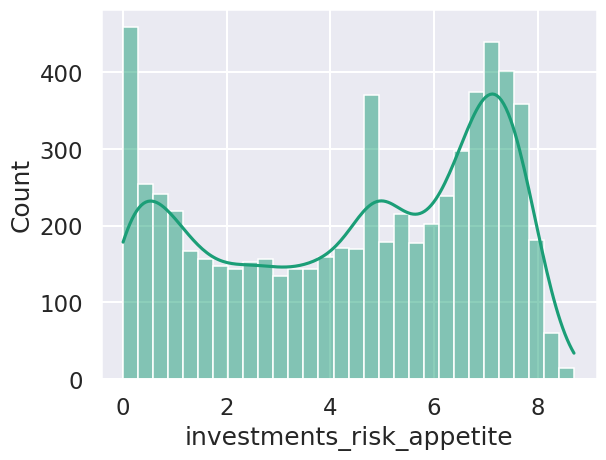

In [151]:
sns.histplot(train['investments_risk_appetite'], bins=30, kde=True)
plt.show()

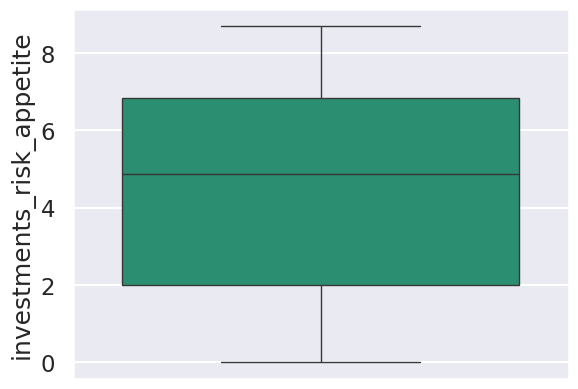

In [152]:
sns.boxplot(train['investments_risk_appetite'])
plt.show()

### Investment Risk Tolerance

In [153]:
train["investments_risk_tolerance"].isnull().sum()

np.int64(127)

In [154]:
train["investments_risk_tolerance"].describe()

,investments_risk_tolerance
count,6404.000000
mean,7.320780
std,3.696520
min,1.393700
25%,4.802475
50%,6.220600
75%,8.562725
max,29.513200


In [155]:
#Fill nulls with grouped medians

investments_risk_tolerance_median = train.groupby('investments_risk_appetite')['investments_risk_tolerance'].transform('median')
train['investments_risk_tolerance'] = train['investments_risk_tolerance'].fillna(investments_risk_tolerance_median)

#Fallback to global median for remaining NaNs
investments_risk_tolerance_global_median = train['investments_risk_tolerance'].median()
train['investments_risk_tolerance'] = train['investments_risk_tolerance'].fillna(investments_risk_tolerance_global_median)

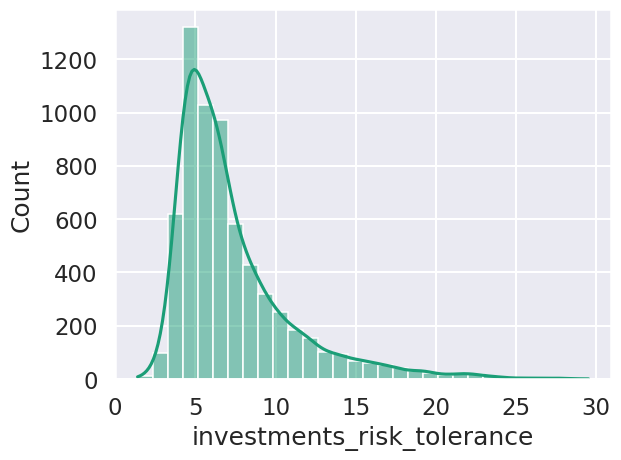

In [156]:
sns.histplot(train['investments_risk_tolerance'], bins=30, kde=True)
plt.show()

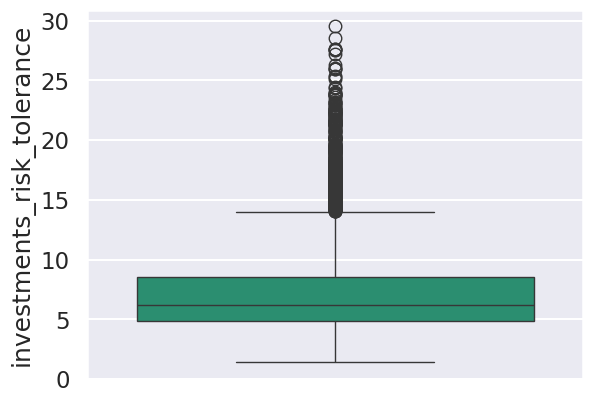

In [157]:
sns.boxplot(train['investments_risk_tolerance'])
plt.show()

In [158]:
# Scale it using log
train['investments_risk_tolerance_scaled'] = np.log1p(train['investments_risk_tolerance'])

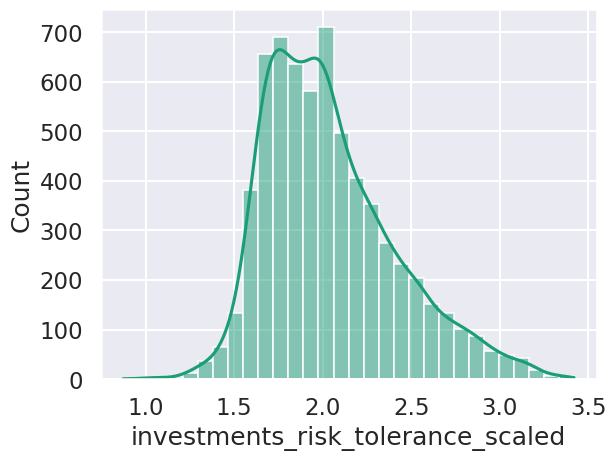

In [159]:
sns.histplot(train['investments_risk_tolerance_scaled'], bins=30, kde=True)
plt.show()

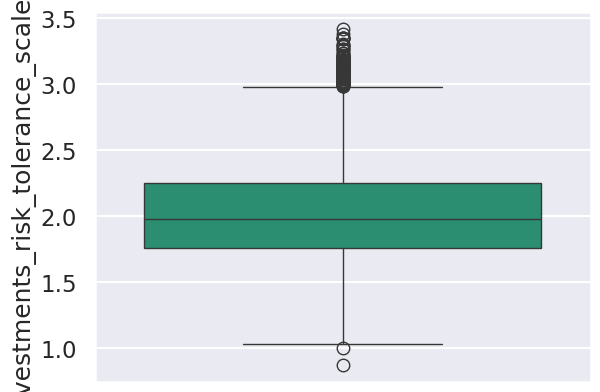

In [160]:
sns.boxplot(train['investments_risk_tolerance_scaled'])
plt.show()

## Create dummy variables

To prepare categorical variables for machine learning algorithms, we converted the selected columns (`continent`, `marital_status`, and `gender`) into dummy variables. This transformation allows algorithms to process non-numeric features by representing each category as a separate binary column.

In [161]:
categorical_cols= train[['continent', 'marital_status', 'gender']]

In [162]:
train = pd.get_dummies(train, columns=categorical_cols.columns) #Added dtype='object'

In [163]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6531 entries, 0 to 6658
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   citizen_id                             6531 non-null   int64   
 1   avg_monthly_entertainment_expenses     6531 non-null   float64 
 2   avg_weekly_exercise_hours              6531 non-null   float64 
 3   country                                6531 non-null   object  
 4   education_level                        6531 non-null   float64 
 5   environmental_awareness_rating         6531 non-null   float64 
 6   financial_wellness_index               6531 non-null   float64 
 7   health_consciousness_rating            6531 non-null   float64 
 8   investment_portfolio_value             6531 non-null   float64 
 9   investments_risk_appetite              6531 non-null   float64 
 10  investments_risk_tolerance             6531 non-null   float64 
 

In [164]:
train_cleaned= train.copy()

We dropped redundant reference categories (e.g., `continent_Unknown`, `gender_Neutral`) to avoid the dummy variable trap and multicollinearity issues.

In [165]:
columns_to_drop = [
    'citizen_id',
    'country',
    'education_category',
    'environmental_awareness_rating',
    'health_consciousness_rating',
    'avg_weekly_exercise_hours',
    'investment_portfolio_value',
    'investments_risk_tolerance',
    'social_media_influence_score',
    'continent_Unknown',  # to avoid dummy variable trap
    'education_category',
    'gender_Neutral',
    "financial_wellness_category"
]

train_cleaned = train.drop(columns=columns_to_drop, errors='ignore')

In [166]:
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6531 entries, 0 to 6658
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   avg_monthly_entertainment_expenses     6531 non-null   float64
 1   education_level                        6531 non-null   float64
 2   financial_wellness_index               6531 non-null   float64
 3   investments_risk_appetite              6531 non-null   float64
 4   lifestyle                              6531 non-null   object 
 5   stress_management_score                6531 non-null   float64
 6   well_being_level                       6531 non-null   float64
 7   age                                    6531 non-null   int32  
 8   environmental_awareness_rating_scaled  6531 non-null   float64
 9   health_consciousness_rating_scaled     6531 non-null   float64
 10  avg_weekly_exercise_hours_scaled       6531 non-null   float64
 11  investmen

## Selecting most important features for the model

In this step, we cleaned the dataset by dropping unused, redundant, or raw versions of already-scaled variables. Features such as `citizen_id`, raw continuous variables, and previously encoded categorical labels were removed.

We then used ANOVA F-score (via `SelectKBest`) to statistically assess and rank each feature’s importance in predicting the target variable `lifestyle`. The most discriminative features were retained based on their F-score, ensuring that only highly relevant predictors remained in the final dataset.

In [167]:
# X = features, y = target
X = train_cleaned.drop('lifestyle', axis=1)
y = train_cleaned['lifestyle']

# ANOVA F-score
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Get scores
scores = pd.DataFrame({
    'Feature': X.columns,
    'F_score': selector.scores_
}).sort_values(by='F_score', ascending=False)

print(scores)


                                  Feature      F_score
9        avg_weekly_exercise_hours_scaled  3313.789179
11    social_media_influence_score_scaled  1163.899147
5                        well_being_level   474.651942
8      health_consciousness_rating_scaled   312.291546
12      investments_risk_tolerance_scaled   310.759504
4                 stress_management_score   288.712457
10      investment_portfolio_value_scaled   193.952698
7   environmental_awareness_rating_scaled    41.065130
0      avg_monthly_entertainment_expenses    23.367043
1                         education_level    23.018452
3               investments_risk_appetite    16.437801
2                financial_wellness_index     3.074668
6                                     age     1.206362
17                continent_South America     1.080685
14                       continent_Europe     0.898926
13                         continent_Asia     0.649535
15                continent_North America     0.412478
18        

Top Predictive Features:

  * `avg_weekly_exercise_hours_scaled`

  * `social_media_influence_score_scaled`

  * `well_being_level`

  * `health_consciousness_rating_scaled`

  * `investments_risk_tolerance_scaled`



Drop the columns with F score bellow 16

In [168]:
columns_to_drop = ["environmental_awareness_rating_scaled",
                   "financial_wellness_index",
                   "age",
                   "marital_status_Single",
                   "marital_status_Married",
                   "continent_South America",
                   "continent_Europe",
                   "continent_Asia",
                   "continent_North America",
                   "gender_F",
                   "gender_M",
                   "continent_Oceania",
                   "education_level",
                   "avg_monthly_entertainment_expenses"
]

train_cleaned = train_cleaned.drop(columns=columns_to_drop, errors='ignore')

## Scale the data

To ensure fair contribution of all numerical features, we applied **MinMax Scaling** on the final cleaned dataset. This was necessary because many classification models are sensitive to the magnitude of the input values. Scaling all features to a [0, 1] range ensured uniformity and improved model convergence, especially for distance-based algorithms like KNN or SVM.

In [169]:
X_train = train_cleaned.drop(['lifestyle'], axis=1)
y_train = train_cleaned['lifestyle']

minmax_scaler = MinMaxScaler().fit(X_train)
minmax_train = minmax_scaler.transform(X_train)

X_train = pd.DataFrame(minmax_train, columns = X_train.columns, index = X_train.index)
X_train.head()

,investments_risk_appetite,stress_management_score,well_being_level,health_consciousness_rating_scaled,avg_weekly_exercise_hours_scaled,investment_portfolio_value_scaled,social_media_influence_score_scaled,investments_risk_tolerance_scaled
0,0.443209,0.653482,0.592512,0.419510,0.005729,0.465138,0.549821,0.271517
1,0.123777,0.477548,0.367942,0.245444,0.034763,0.536362,0.462029,0.466165
2,0.211874,0.540054,0.624790,0.567938,0.043603,0.431472,0.412706,0.348361
3,0.138801,0.300065,0.538225,0.656593,0.487511,0.537881,0.711913,0.306874
4,0.111834,0.290978,0.224301,0.235117,0.503775,0.506373,0.502696,0.391593


 # 4. VALIDATION DATA

## Duplicate Data Cleaning

 As checked for duplicate rows but didn’t find any, then we set `citizen_id` as the index because it is a unique ID for each person. Then we will check for duplicates again.

In [170]:
val.set_index("citizen_id", inplace = True)
val.head()

,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,hapiness_level,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
citizen_id,,,,,,,,,,,,,,,,,,,,,
5189,42.6436,0.0322,Orihuela,Spain,1987-03-24,NaN,3.4164,0.6643,135.0590,medium,...,7.4046,10.5116,0.0000,Investor,,Esperanza,4.4301,4.2903,Ms.,5.1089
6288,23.8131,0.5332,Landsberg,Germany,1985-04-20,0.1442,13.5767,3.2191,4.7746,medium,...,3.0420,6.4748,1.6751,Health-Conscious,,Rahel,14.8847,5.4277,Mrs.,6.0369
3800,8.1143,0.0354,Fitjar,Norway,1989-01-22,0.0105,1.0172,0.7063,19.0508,medium,...,NaN,7.8393,NaN,Investor,,Bertine,3.5703,3.7834,Mx.,4.4397
7801,7.2176,0.7985,San Felipe Aztatán,Mexico,1985-12-12,0.0000,4.8285,0.7262,98.8675,medium,...,0.9624,3.5603,0.0000,Health-Conscious,,Miguel,19.0869,2.9559,Mr.,5.5547
3870,52.1120,0.3162,Oure,Denmark,1981-10-05,0.0091,0.2081,0.7242,123.3150,medium,...,0.1483,7.9954,0.0000,Investor,,Storm,5.3712,4.2599,Mr.,4.8712


In [171]:
val.duplicated().sum()

np.int64(1)

We still identified 1 duplicated rows, so we inspected the duplicates in detail:

In [172]:
#locate the duplicate rows with .loc, showing both of the duplicates (the original and the duplicated for each case)
val.loc[val.duplicated(keep=False), :]

,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,hapiness_level,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
citizen_id,,,,,,,,,,,,,,,,,,,,,
863,7.8511,0.051,Chichimequillas,Mexico,1985-05-25,0.008,2.5868,0.6178,156.527,medium,...,1.5796,5.8004,0.0,Investor,,Mariano,3.3144,2.3453,Mr.,3.3506
872,7.8511,0.051,Chichimequillas,Mexico,1985-05-25,0.008,2.5868,0.6178,156.527,medium,...,1.5796,5.8004,0.0,Investor,,Mariano,3.3144,2.3453,Mr.,3.3506


We drop the duplicate:

In [173]:
# Removing the duplicates
val.drop_duplicates(inplace=True)
val.duplicated().sum()

np.int64(0)

Finally, we restored the original structure of the DataFrame to include `citizen_id` as a column again:

In [174]:
val = val.reset_index(drop = False)
val.head()

,citizen_id,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
0,5189,42.6436,0.0322,Orihuela,Spain,1987-03-24,NaN,3.4164,0.6643,135.0590,...,7.4046,10.5116,0.0000,Investor,,Esperanza,4.4301,4.2903,Ms.,5.1089
1,6288,23.8131,0.5332,Landsberg,Germany,1985-04-20,0.1442,13.5767,3.2191,4.7746,...,3.0420,6.4748,1.6751,Health-Conscious,,Rahel,14.8847,5.4277,Mrs.,6.0369
2,3800,8.1143,0.0354,Fitjar,Norway,1989-01-22,0.0105,1.0172,0.7063,19.0508,...,NaN,7.8393,NaN,Investor,,Bertine,3.5703,3.7834,Mx.,4.4397
3,7801,7.2176,0.7985,San Felipe Aztatán,Mexico,1985-12-12,0.0000,4.8285,0.7262,98.8675,...,0.9624,3.5603,0.0000,Health-Conscious,,Miguel,19.0869,2.9559,Mr.,5.5547
4,3870,52.1120,0.3162,Oure,Denmark,1981-10-05,0.0091,0.2081,0.7242,123.3150,...,0.1483,7.9954,0.0000,Investor,,Storm,5.3712,4.2599,Mr.,4.8712


## Categorical Features Cleaning

### Country

In [175]:
# Count how many entries belong to each country
val['country'].value_counts()

,count
country,
Brazil,94
Spain,91
Ukraine,91
France,84
Germany,83
Mexico,81
Finland,81
United States,81
Norway,80


We wanted to check if the rows with blank countries had a city, so we could assign the country to where that city is from.

In [176]:
# Find rows where the 'country' column is blank or contains only spaces
val[val['country'] == '  ']

,citizen_id,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
85,1410,40.5889,0.0384,Nr Åby,,1987-02-19,0.0000,5.4621,0.8454,1.2120,...,4.5772,5.3574,0.0000,Investor,,Amalie,5.5088,3.5260,Ms.,4.2237
215,997,44.8958,0.1385,Hierden,,1996-12-16,0.0338,12.9441,1.7812,107.5750,...,6.2374,11.2281,1.1148,Investor,,Edna,6.1225,6.2923,Ms.,7.0983
337,1256,7.9081,2.7561,South Bend,,1988-04-17,0.0079,7.9494,1.1388,97.4430,...,1.8747,6.3465,0.0000,Fitness Enthusiast,,Serenity,1.5746,1.4925,Ms.,2.3446
433,7318,21.2572,0.3944,Ennetbürgen,,2000-03-24,0.0000,0.8718,0.4974,100.5350,...,4.4622,5.4095,0.0000,Fitness Enthusiast,,Aurora,7.8911,1.3701,Mrs.,2.7510
622,1879,43.1303,1.5229,Eptingen,,1960-01-03,0.0016,8.2628,0.7112,104.9580,...,8.3697,8.5657,0.0000,Fitness Enthusiast,,Pierre-Alain,12.7194,2.8397,Mr.,3.0176
743,4442,8.1471,4.3612,آبادان,,1983-11-26,0.0000,5.4378,2.3212,101.5210,...,7.1480,11.3944,0.0000,Fitness Enthusiast,,آوین,2.0496,2.3819,Ms.,3.2301
774,6397,6.2850,0.0123,Bonstetten,,1988-02-18,0.0041,2.6333,0.6076,93.9390,...,7.8134,9.8837,1.3986,Health-Conscious,,Angel,1.8559,3.2899,Mr.,5.1056
780,404,40.5490,0.0350,Bayreuth,,2000-09-01,0.0119,3.4263,0.7543,288.8720,...,7.6578,10.7330,0.0000,Investor,,Karlfried,4.4864,4.3776,Mr.,5.1222
781,4337,17.3951,0.2114,Flatrock,,1910-03-22,0.0000,5.3246,0.5470,182.7860,...,6.3604,NaN,0.0000,Investor,,Juliette,1.6849,2.1301,Mrs.,2.8532
1019,2031,7.7549,4.2805,Georgetown,,2005-01-20,0.0000,3.7966,0.6501,97.2467,...,4.0504,4.8034,0.0000,Fitness Enthusiast,,Zackary,8.9267,2.3143,Mr.,2.6380


We then check all cities with a blank country to see if the same city appears elsewhere with a valid country, so we can use that value to fill in the missing one

In [177]:
#Create a city-to-country mapping from valid data
city_country_map = val[val['country'].str.strip() != ''].groupby('city')['country'].agg(lambda x: x.mode()[0]).to_dict()

#Loop through rows where country is blank
for idx in val[val['country'] == '  '].index:
    city = val.at[idx, 'city']
    if city in city_country_map:
        val.at[idx, 'country'] = city_country_map[city]

#check if any blank values remain
print("Blank country entries after filling:", (val['country'] == '  ').sum())

Blank country entries after filling: 9


In [178]:
val[val['country'] == '  ']

,citizen_id,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,...,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,lifestyle,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
85,1410,40.5889,0.0384,Nr Åby,,1987-02-19,0.0000,5.4621,0.8454,1.2120,...,4.5772,5.3574,0.0000,Investor,,Amalie,5.5088,3.5260,Ms.,4.2237
215,997,44.8958,0.1385,Hierden,,1996-12-16,0.0338,12.9441,1.7812,107.5750,...,6.2374,11.2281,1.1148,Investor,,Edna,6.1225,6.2923,Ms.,7.0983
337,1256,7.9081,2.7561,South Bend,,1988-04-17,0.0079,7.9494,1.1388,97.4430,...,1.8747,6.3465,0.0000,Fitness Enthusiast,,Serenity,1.5746,1.4925,Ms.,2.3446
433,7318,21.2572,0.3944,Ennetbürgen,,2000-03-24,0.0000,0.8718,0.4974,100.5350,...,4.4622,5.4095,0.0000,Fitness Enthusiast,,Aurora,7.8911,1.3701,Mrs.,2.7510
622,1879,43.1303,1.5229,Eptingen,,1960-01-03,0.0016,8.2628,0.7112,104.9580,...,8.3697,8.5657,0.0000,Fitness Enthusiast,,Pierre-Alain,12.7194,2.8397,Mr.,3.0176
774,6397,6.2850,0.0123,Bonstetten,,1988-02-18,0.0041,2.6333,0.6076,93.9390,...,7.8134,9.8837,1.3986,Health-Conscious,,Angel,1.8559,3.2899,Mr.,5.1056
780,404,40.5490,0.0350,Bayreuth,,2000-09-01,0.0119,3.4263,0.7543,288.8720,...,7.6578,10.7330,0.0000,Investor,,Karlfried,4.4864,4.3776,Mr.,5.1222
781,4337,17.3951,0.2114,Flatrock,,1910-03-22,0.0000,5.3246,0.5470,182.7860,...,6.3604,NaN,0.0000,Investor,,Juliette,1.6849,2.1301,Mrs.,2.8532
1019,2031,7.7549,4.2805,Georgetown,,2005-01-20,0.0000,3.7966,0.6501,97.2467,...,4.0504,4.8034,0.0000,Fitness Enthusiast,,Zackary,8.9267,2.3143,Mr.,2.6380


Since only the cities without a valid country remain, we will now assign them to their respective countries.

In [179]:
city_to_country = {
    'Nr Åby': 'Denmark',
    'Hierden': 'Netherlands',
    'South Bend': 'United States',
    'Ennetbürgen': 'Switzerland',
    'Eptingen': 'Switzerland',
    'Bonstetten': 'Switzerland',
    'Bayreuth': 'Germany',
    'Flatrock': 'Canada',
    'Georgetown': 'United States',
}

In [180]:
# Update only matching rows in the 'country' column using exact keys
val['country'] = val['city'].map(city_to_country).fillna(val['country'])

# Check if any blank values remain
print("Blank country entries after filling:", (val['country'] == '  ').sum())

Blank country entries after filling: 0


### Continent

We will then assign each country to it's respective continent for reginal analysis.

In [181]:
val['continent'] = val['country'].map(country_to_continent_map).fillna('Unknown')

### Title and Marital Status


We will strategically use '`title`' and '`marital_status`' to get '`gender`', as gender provides clearer insights for analysis.


In [182]:
# Check all unqiue values for title
val["title"].unique()

array(['Ms.', 'Mrs.', 'Mx.', 'Mr.'], dtype=object)

We will now get marital status from the unique titles and fill the cloumn appropiately.

In [183]:
# Set entire marital_status column to null
val['marital_status'] = np.nan

In [184]:
# Fill marital_status for Ms. and Mrs.
val.loc[val['title'] == 'Ms.', 'marital_status'] = 'Single'
val.loc[val['title'] == 'Mrs.', 'marital_status'] = 'Married'

# Calculate the proportion of married individuals among Ms. and Mrs.
marriage_proportion = val['marital_status'].value_counts(normalize=True)['Married']
print(f"Proportion of married individuals: {marriage_proportion:.2f}")


Proportion of married individuals: 0.51


In [185]:
# Filter rows where marital_status is still missing
mask = val['marital_status'].isna() & val['title'].isin(['Mr.', 'Mx.'])

# Randomly assign marital status based on observed proportion
val.loc[mask, 'marital_status'] = np.random.choice(['Married', 'Single'],
                                                     size=mask.sum(),
                                                     p=[marriage_proportion, 1 - marriage_proportion])

Marital Status Counts:

marital_status
Married    864
Single     801
Name: count, dtype: int64


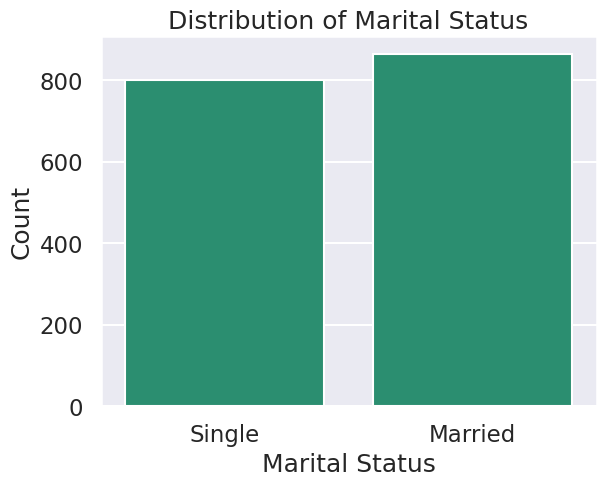

In [186]:
# Show marital status value counts and visualize them
print("Marital Status Counts:\n")
print(val["marital_status"].value_counts())

sns.countplot(data=val, x='marital_status')
plt.title("Distribution of Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.show()

Now we will convert title to gender attributes. For example, 'Mr' becomes 'M', 'Ms'/'Mrs' become 'F' and 'Mx' become 'Neutral'.

In [187]:
val["title"] = val["title"].replace({"Mr.":"M","Ms.":"F","Mrs.":"F","Mx.":"Neutral"})
val.rename(columns={"title":"gender"}, inplace=True) #Rename the column
val["gender"].unique() #To verify it's features

array(['F', 'Neutral', 'M'], dtype=object)

Gender Counts:

gender
F          815
M          810
Neutral     40
Name: count, dtype: int64


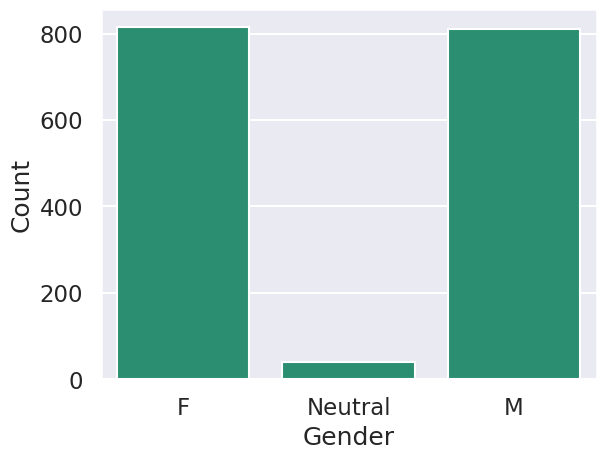

In [188]:
# Show gender value counts and visualize them
print("Gender Counts:\n")
print(val["gender"].value_counts())

sns.countplot(data=val, x='gender')
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

### Date Of Birth

Similar to title and marital column we convert date of birth to age for better usability in analysis and modeling

In [189]:
# Convert the DOB column to age and drop the date_of_birth column (assuming 01/01/2025)
val["date_of_birth"] = pd.to_datetime(val["date_of_birth"]) # First convert the val type from object to datetime
val["age"] = 2025 - val["date_of_birth"].dt.year

In [190]:
# Drop DOB column
val.drop(columns=["date_of_birth"], inplace=True)

In [191]:
val["age"].describe()

,age
count,1665.000000
mean,36.983183
std,13.551751
min,1.000000
25%,28.000000
50%,36.000000
75%,44.000000
max,115.000000


We will now remove ages below 18 and above 100 to focus on realistic adult participants, as the data involves financial behavior, wellness, and lifestyle metrics that are not relevant for children or extremely old age outliers.

In [192]:
val = val[(val["age"] >= 18) & (val["age"] <= 100)]

### City, Happiness Level & Name

So after careful examining we decided we will not be using the `name`, `city`, and `hapiness_level` columns for further analysis. These columns either contain high-cardinality values or lack meaningful patterns for modeling, so we've decided to drop them.

Name will have no use for us, city already served its purpose for mapping the countries and hapiness level only had one value which would not be usefull.

In [193]:
# Count the values for hapiness level
val["hapiness_level"].value_counts()

,count
hapiness_level,
medium,1624


In [194]:
val.drop(columns=['city', 'hapiness_level', 'name'], inplace=True)


# Remove from categorical list
for col in ['name', 'hapiness_level', 'city']:
    if col in categorical_features:
        categorical_features.remove(col)

### Education Level and Financial Wellness Index

These two columns, `education_level` and `financial_wellness_index` are originally numerical variables but we wanted to create a categorical versions to use later in our clustering and analysis.



---


Firstly, we are converting European-style decimal notation to Python-compatible float format using string replacement:

In [195]:
for col in ['education_level', 'financial_wellness_index']:
    val[col] = (
        val[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

In [196]:
val[['education_level', 'financial_wellness_index']].describe()

,education_level,financial_wellness_index
count,1569.000000,1586.000000
mean,6.348696,105.802908
std,2.911885,64.253874
min,0.000000,-0.050000
25%,4.056400,87.027325
50%,6.439300,99.925150
75%,8.788800,113.285250
max,13.598100,385.529000


Now we will handle missing values of both `education_level` and `financial_wellness_index` seperately in the best possible ways.

**Education Level**

First by using group-wise medians based on age, assuming educational level correlates with age.

Any remaining nulls are imputed using the global median.

In [197]:
# Fill nulls with grouped medians
val['education_level'] = val['education_level'].fillna(
    val['age'].map(grouped_median)
)

val['education_level'] = val['education_level'].fillna(global_median)

To enhance interpretability, we map the education levels into meaningful categories:

In [198]:
# Apply function and store in a new column
val['education_category'] = val['education_level'].apply(categorize_education)

# Convert new column to ordered categorical type
val['education_category'] = pd.Categorical(val['education_category'], categories=education_order, ordered=True)

**Financial Wellness Index**

We convert the values from string to float, and clip all the negative values to zero.

We also fill the missing values via random sampling from the existing distribution to retain realistic variance.

In [199]:
# Replace any negative values in financial_wellness_index with 0
val['financial_wellness_index'] = val['financial_wellness_index'].clip(lower=0)

val['financial_wellness_index'] = random_sample_impute(val['financial_wellness_index'])

We group financial scores into three simplified tiers:

In [200]:
# Convert financial wellness index into categorical levels: Low, Medium, and High for better interpretation
val['financial_wellness_category'] = val['financial_wellness_index'].apply(convert_to_financial_wellness_level)

In [201]:
# Verify category assignments for education and financial wellness
val[['education_level', 'education_category',
      'financial_wellness_index', 'financial_wellness_category',
      'age']].head(10)

,education_level,education_category,financial_wellness_index,financial_wellness_category,age
0,3.4164,Primary School,135.0590,High,38
1,13.5767,Master's or Higher,4.7746,Low,40
2,1.0172,Primary School,19.0508,Low,36
3,4.8285,Middle School,98.8675,Medium,40
4,0.2081,No formal education,123.3150,Medium,44
5,2.8411,Primary School,230.6130,High,23
6,7.8336,Middle School,101.5300,Medium,49
7,1.4008,Primary School,119.2290,Medium,37
8,6.0710,Middle School,87.5024,Medium,52
9,5.0971,Middle School,97.6512,Medium,21


The following visualizations are created to support data quality checks and analysis:

## Numerical Features Cleaning

In this section we will go column by column taking care of nulls, outliers, skewness and other things that might need to be worked on , along with exploratory data analysis. Also, keep in mind that whenever we use a function to scale the data we create a new column with "scaled" so we can later use it for modelling. Our goal is to normalize the data and minimize the outliers, which we will check with histplots and boxplots for each column.

In [202]:
# Create a for loop to convert every numerical feature to float
for feature in numerical_features:
    val[feature] = (
        val[feature]
        .astype(str)  # Ensure it's a string first
        .str.replace(',', '.')  # Replace commas with dots
        .astype(float)
        )

In [203]:
val[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
financial_wellness_index,1624.0,106.129606,64.316614,0.0000,87.239900,99.97915,113.740500,385.5290
investment_portfolio_value,1608.0,11.541548,18.294436,0.0000,3.015300,7.87355,13.082200,179.3500
social_media_influence_score,1624.0,6.048916,4.324250,0.2526,3.139025,4.37860,7.958450,28.0880
investments_risk_appetite,1578.0,4.243748,2.693568,0.0000,1.626300,4.50740,6.867250,8.6160
investments_risk_tolerance,1591.0,7.239097,3.557698,2.2165,4.779900,6.22450,8.451950,29.0164
avg_monthly_entertainment_expenses,1570.0,21.235646,17.545909,1.8439,7.932625,11.49210,38.737575,130.6420
avg_weekly_exercise_hours,1584.0,0.717847,1.161474,-4.5495,0.021150,0.10980,1.114525,6.6656
stress_management_score,1571.0,3.297328,1.064690,0.6737,2.578150,3.12650,3.957000,7.6535
well_being_level,1600.0,4.710516,1.866972,1.3678,3.407850,4.27800,5.472325,13.9572
environmental_awareness_rating,1618.0,0.854277,0.710615,0.0883,0.541250,0.63190,0.784575,7.0443


We will start with understanding the relationship of numerical features with each other so we can choose how to deal with them.

### Environmental Awareness Rating

In [204]:
val['environmental_awareness_rating'].isnull().sum()

np.int64(6)

In [205]:
#Fix null values ()
val['environmental_awareness_rating'] = val['environmental_awareness_rating'].fillna(
    environmental_awareness_rating_median
)

In [206]:
#Log transform to scale (log1p handles 0 safely)
val['environmental_awareness_rating_scaled'] = np.log1p(val['environmental_awareness_rating'])

Applied RobustScaler to reduce influence of outliers while preserving data structure

In [207]:
#Scale using RobustScaler
val['environmental_awareness_rating_scaled'] = env_scaler.transform(val[['environmental_awareness_rating_scaled']])

### Health Consciousness Rating

In [208]:
val['health_consciousness_rating'].isnull().sum()

np.int64(41)

In [209]:
#Fill nulls with grouped medians of the validation data
val['health_consciousness_rating'] = val['health_consciousness_rating'].fillna(health_consciousness_rating_median)

#Fallback to global median for remaining NaNs
val['health_consciousness_rating'] = val['health_consciousness_rating'].fillna(health_consciousness_rating_global_median)

In [210]:
#Log transform (log1p handles 0 safely)
val['health_consciousness_rating_scaled'] = np.log1p(val['health_consciousness_rating'])

In [211]:
#Scale using RobustScaler
val['health_consciousness_rating_scaled'] = health_scaler.transform(val[['health_consciousness_rating_scaled']])

### Avg Monthly Entertainment Expenses

In [212]:
#check for missing values
val['avg_monthly_entertainment_expenses'].isnull().sum()

np.int64(54)

In [213]:
#Fill nulls with grouped medians
val['avg_monthly_entertainment_expenses'] = val['avg_monthly_entertainment_expenses'].fillna(avg_monthly_entertainment_expenses_median)

val['avg_monthly_entertainment_expenses'] = val['avg_monthly_entertainment_expenses'].fillna(avg_monthly_entertainment_expenses_global_median)

### Avg Weekly Exercise Hours

In [214]:
#check nulls
val['avg_weekly_exercise_hours'].isnull().sum()

np.int64(40)

In [215]:
#Fill nulls with median value of the validation data
val['avg_weekly_exercise_hours'] = val['avg_weekly_exercise_hours'].fillna(avg_weekly_exercise_hours_median)

We notice that we have negative hours for a varaible that shoult had negative values, so we decide do cap the lower bound to 0 since its the minimal possible value.

In [216]:
#lower bound to 0
val['avg_weekly_exercise_hours'] = val['avg_weekly_exercise_hours'].clip(lower=0)

In [217]:
# Log transformation (add 1 to handle zeros)
val['avg_weekly_exercise_hours_scaled'] = np.log1p(val['avg_weekly_exercise_hours'])

### Stress Management Score

In [218]:
val["stress_management_score"].isnull().sum()

np.int64(53)

The highest correlations we had on all the columns was 0.75 between stress management score and well being level, so we will use it to fill the nulls

In [219]:
#highest correlation is with well being level, 0.75
#Fill nulls with grouped medians by the traning data
val['stress_management_score'] = val['stress_management_score'].fillna(stress_management_score_median)

#Fallback to global median for remaining NaNs
val['stress_management_score'] = val['stress_management_score'].fillna(stress_management_score_median_global_median)

### Eco Consciousness Score (Dropped)

In [220]:
#drop column
val.drop('eco_consciousness_score', axis=1, inplace=True)

### Well Being Level

In [221]:
val["well_being_level"].isnull().sum()

np.int64(24)

We decided to use the KNN imputer to fill in the missing values for `well_being_level` using `stress_management_score` and `health_consciousness_rating`, since these features are related (0.75 and 0.67) and can help estimate the missing values more accurately.

In [222]:
#transform
imputed_array = imputer.transform(val[cols])

In [223]:
val['well_being_level'] = imputed_array[:, 0]

### Last Year Charity Donations (Dropped)

In [224]:
#drop the column
val.drop('last_year_charity_donations', axis=1, inplace=True)

Like the eco consciousness score, we decided that this column is also not useful for our analysis as it was very skewed, so we decided to drop it.

### Investment Portfolio Value

In [225]:
val["investment_portfolio_value"].isnull().sum()

np.int64(16)

In [226]:
val['investment_portfolio_value'] = val['investment_portfolio_value'].fillna(investment_portfolio_value_median)

#Fallback to global median for remaining NaNs
val['investment_portfolio_value'] = val['investment_portfolio_value'].fillna(investment_portfolio_value_global_median)

In [227]:
val['investment_portfolio_value_scaled'] = np.log1p(val['investment_portfolio_value'])

### Social Media Influence Score

In [228]:
val["social_media_influence_score"].isnull().sum()

np.int64(0)

In [229]:
#using the log scaler
val['social_media_influence_score_scaled'] = np.log1p(val['social_media_influence_score'])

### Investment Risk Appetite

In [230]:
val["investments_risk_appetite"].isnull().sum()

np.int64(46)

In [231]:
#Fill nulls with grouped medians from the column with highest correlation by the validation data
val['investments_risk_appetite'] = val['investments_risk_appetite'].fillna(investments_risk_appetite_median)

#Fallback to global median for remaining NaNs
val['investments_risk_appetite'] = val['investments_risk_appetite'].fillna(investments_risk_appetite_global_median)

### Investment Risk Tolerance

In [232]:
val["investments_risk_tolerance"].isnull().sum()

np.int64(33)

In [233]:
#Fill nulls with grouped medians
val['investments_risk_tolerance'] = val['investments_risk_tolerance'].fillna(investments_risk_tolerance_median)

#Fallback to global median for remaining NaNs
val['investments_risk_tolerance'] = val['investments_risk_tolerance'].fillna(investments_risk_tolerance_global_median)

In [234]:
# Scale it using log
val['investments_risk_tolerance_scaled'] = np.log1p(val['investments_risk_tolerance'])

## Create dummy variables

To prepare categorical variables for machine learning algorithms, we converted the selected columns (`continent`, `marital_status`, and `gender`) into dummy variables. This transformation allows algorithms to process non-numeric features by representing each category as a separate binary column.

In [235]:
categorical_cols= val[['continent', 'marital_status', 'gender']]

In [236]:
val = pd.get_dummies(val, columns=categorical_cols.columns) #Added dtype='object'

In [237]:
val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1624 entries, 0 to 1664
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   citizen_id                             1624 non-null   int64   
 1   avg_monthly_entertainment_expenses     1624 non-null   float64 
 2   avg_weekly_exercise_hours              1624 non-null   float64 
 3   country                                1624 non-null   object  
 4   education_level                        1624 non-null   float64 
 5   environmental_awareness_rating         1624 non-null   float64 
 6   financial_wellness_index               1624 non-null   float64 
 7   health_consciousness_rating            1624 non-null   float64 
 8   investment_portfolio_value             1624 non-null   float64 
 9   investments_risk_appetite              1624 non-null   float64 
 10  investments_risk_tolerance             1624 non-null   float64 
 

In [238]:
val_cleaned= val.copy()

We dropped redundant reference categories (e.g., `continent_Unknown`, `gender_Neutral`) to avoid the dummy variable trap and multicollinearity issues.

In [239]:
columns_to_drop = [
    'citizen_id',
    'country',
    'education_category',
    'environmental_awareness_rating',
    'health_consciousness_rating',
    'avg_weekly_exercise_hours',
    'investment_portfolio_value',
    'investments_risk_tolerance',
    'social_media_influence_score',
    'continent_Unknown',  # to avoid dummy variable trap
    'education_category',
    'gender_Neutral',
    "financial_wellness_category"
]

val_cleaned = val.drop(columns=columns_to_drop, errors='ignore')

## Selecting most important features for the model

In this step, we cleaned the dataset by dropping unused, redundant, or raw versions of already-scaled variables. Features such as `citizen_id`, raw continuous variables, and previously encoded categorical labels were removed.

We then used ANOVA F-score (via `SelectKBest`) to statistically assess and rank each feature’s importance in predicting the target variable `lifestyle`. The most discriminative features were retained based on their F-score, ensuring that only highly relevant predictors remained in the final dataset.

In [240]:
# X = features, y = target
X = val_cleaned.drop('lifestyle', axis=1)
y = val_cleaned['lifestyle']

# ANOVA F-score
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Get scores
scores = pd.DataFrame({
    'Feature': X.columns,
    'F_score': selector.scores_
}).sort_values(by='F_score', ascending=False)

print(scores)


                                  Feature     F_score
9        avg_weekly_exercise_hours_scaled  848.762428
11    social_media_influence_score_scaled  256.358349
5                        well_being_level  135.394656
8      health_consciousness_rating_scaled  104.422853
12      investments_risk_tolerance_scaled   84.450676
10      investment_portfolio_value_scaled   73.161098
4                 stress_management_score   69.566855
7   environmental_awareness_rating_scaled   29.283370
1                         education_level   11.461251
0      avg_monthly_entertainment_expenses   10.453157
21                               gender_M    4.163844
20                               gender_F    3.785912
3               investments_risk_appetite    3.020324
6                                     age    1.438418
2                financial_wellness_index    1.213391
13                         continent_Asia    0.802709
15                continent_North America    0.711212
17                continent_

**Top Predictive Features:**

  * `avg_weekly_exercise_hours_scaled`

  * `social_media_influence_score_scaled`

  * `well_being_level`

  * `health_consciousness_rating_scaled`

  * `investments_risk_tolerance_scaled`

Drop the columns with weak F score:


In [241]:
columns_to_drop = ["environmental_awareness_rating_scaled",
                   "financial_wellness_index",
                   "age",
                   "marital_status_Single",
                   "marital_status_Married",
                   "continent_South America",
                   "continent_Europe",
                   "continent_Asia",
                   "continent_North America",
                   "gender_F",
                   "gender_M",
                   "continent_Oceania",
                   "education_level",
                   "avg_monthly_entertainment_expenses"
]

val_cleaned = val_cleaned.drop(columns=columns_to_drop, errors='ignore')

## Scale the data

To ensure fair contribution of all numerical features, we applied **MinMax Scaling** on the final cleaned dataset. This was necessary because many classification models are sensitive to the magnitude of the input values. Scaling all features to a [0, 1] range ensured uniformity and improved model convergence, especially for distance-based algorithms like KNN or SVM.

In [242]:
X_val = val_cleaned.drop(['lifestyle'], axis=1)
y_val = val_cleaned['lifestyle']

minmax_val = minmax_scaler.transform(X_val)

X_val = pd.DataFrame(minmax_val, columns = X_val.columns, index = X_val.index)
X_val.head()

,investments_risk_appetite,stress_management_score,well_being_level,health_consciousness_rating_scaled,avg_weekly_exercise_hours_scaled,investment_portfolio_value_scaled,social_media_influence_score_scaled,investments_risk_tolerance_scaled
0,0.851152,0.510295,0.393886,0.248914,0.016018,0.518207,0.490441,0.617021
1,0.349675,0.662076,0.486307,0.198001,0.215999,0.000000,0.802226,0.447369
2,0.211874,0.442652,0.327239,0.210008,0.017583,0.415652,0.440371,0.513243
3,0.110627,0.332226,0.438284,0.532983,0.296663,0.530558,0.870402,0.253229
4,0.017047,0.506239,0.370213,0.198544,0.138866,0.267048,0.536866,0.520121


# Grid Search

We implemented an exhaustive GridSearchCV for several classification algorithms:

  * Logistic Regression

  * K-Nearest Neighbors

  * Random Forest

  * Gradient Boosting

  * Linear SVC

  * Hist Gradient Boosting

Each model was paired with a specific parameter grid, and the best configuration was selected based on **macro-averaged F1 Score** with **5-fold cross-validation**. This process allowed us to identify the most effective algorithm and optimal settings, ensuring both performance and generalizability.

This part of the code is commented as it takes forever to run (Approximately 3 hours)

In [243]:
#param_grids = {
#    "Logistic Regression": {
#        "model": LogisticRegression(max_iter=1000, random_state=42),
#        "params": {
#            "penalty": ["l1", "l2"],
#            "C": [0.01, 0.1, 1, 10, 100],
#            "solver": ["liblinear"],  # liblinear é compatível com l1/l2
#            "class_weight": [None, "balanced"]
#        }
#    },
#    "KNN Classifier": {
#        "model": KNeighborsClassifier(),
#        "params": {
#            "n_neighbors": [3, 5, 7, 11, 21],
#            "weights": ["uniform", "distance"],
#            "metric": ["euclidean", "manhattan"]
#        }
#    },
#    "Random Forest": {
#        "model": RandomForestClassifier(random_state=42),
#        "params": {
#            "n_estimators": [100, 200],
#            "max_depth": [10, 20, None],
#            "min_samples_split": [2, 5],
#            "min_samples_leaf": [1, 2],
#            "max_features": ["sqrt", "log2"],
#            "bootstrap": [True, False],
#            "class_weight": ["balanced"]
#        }
#    },
#    "Gradient Boosting": {
#        "model": GradientBoostingClassifier(random_state=42),
#        "params": {
#            "n_estimators": [100, 200],
#            "learning_rate": [0.01, 0.1, 0.2],
#            "max_depth": [3, 5, 7],
#            "min_samples_split": [2, 5],
#            "min_samples_leaf": [1, 3],
#            "subsample": [0.8, 1.0]
#        }
#    },
#    "Linear SVC": {
#        "model": LinearSVC(max_iter=10000, random_state=42),
#        "params": {
#            "C": [0.01, 0.1, 1, 10, 100],
#            "penalty": ["l2"],  # LinearSVC só suporta 'l2'
#            "dual": [True, False],
#            "class_weight": [None, "balanced"]
#        }
#    },
#    "HistGradientBoostingClassifier": {
#        "model": HistGradientBoostingClassifier(random_state=42),
#        "params": {
#            "learning_rate": [0.01, 0.05, 0.1],
#            "max_iter": [100, 200],
#            "max_depth": [None, 10],
#            "min_samples_leaf": [10, 20],
#            "l2_regularization": [0.0, 1.0]
#        }
#    }
#    }

In [244]:
#from sklearn.metrics import make_scorer, f1_score
#
## Define macro F1 scorer
#f1_macro = make_scorer(f1_score, average='macro')
#
#X_data = X_train
#y_data = y_train
#
#best_models = {}
#grid_results = {}
#
#for name, cfg in param_grids.items():
#    print(f"\nRunning GridSearchCV for {name}...")
#    grid = GridSearchCV(
#        estimator=cfg['model'],
#        param_grid=cfg['params'],
#        scoring=f1_macro,
#        cv=5,
#        n_jobs=-1,
#        verbose=1
#    )
#    grid.fit(X_data, y_data)
#
#    best_models[name] = grid.best_estimator_
#    grid_results[name] = {
#        "best_params": grid.best_params_,
#    }
#
#import pandas as pd
#results_df = pd.DataFrame(grid_results).T
#display(results_df)

In [245]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)
#display(results_df)

 # K-Fold Cross-Validation

To evaluate model robustness and reduce variance from data splits, we employed **Stratified K-Fold Cross-Validation** with 10 folds. This ensured that class proportions were maintained across each fold, providing a fair evaluation of model performance on minority classes within our imbalanced target variable.

We embedded all preprocessing steps using information are fully embedded within each fold to prevent data leakage and ensure that transformations are only applied using information available in the training partition. The following operations are performed per fold:

During each fold, we applied the entire preprocessing pipeline, including:

  * **Imputation**: Missing values are filled using training fold medians or random sampling (for financial variables).

  * **Outlier Handling**: Outliers are clipped at 0 for skewed variables to stabilize variance.

  * **Log + Robust Scaling**: Applied to variables like `health_consciousness_rating` and `environmental_awareness_rating` to reduce skew while maintaining robustness.

  * **Feature Engineering**: Scaled variants are created for key predictors like `investment_portfolio_value` and `social_media_influence_score`.

  * **Irrelevant/Duplicate Columns Dropped**: Non-informative fields such as identifiers, original (unscaled) variables, and dropped features like `eco_consciousness_score` are excluded.

  * **Final Normalization**: A `MinMaxScaler` is fit only on the training set and applied to both training and validation subsets.

Each model is trained and tested on the respective splits. The following metrics are calculated and stored:

  * Accuracy

  * Precision (macro)

  * Recall (macro)

  * F1 Score (macro)

  * Runtime (seconds per fold)

We did this for a detailed comparisons of **train vs. validation performance**, assessment of overfitting, and benchmarking of computation time for different models.

The results are returned as a **pandas DataFrame**, with a row for each fold and columns for each metric, making it easy to aggregate, visualize, or compare across models.

In [246]:
def cv_scores(model, X, y):
    '''Function takes as argument the model you intend to use, the predictors and the labels. It splits the data using StratifiedKFold,
    trains model using X and y as predictors and label. Then it returns the results obtained from stratified cross validation'''

    #apply rkfold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 15)

    #create lists to store the results from the different models
    acc_score_train = []
    acc_score_val = []
    precision_score_train = []
    precision_score_val = []
    recall_score_train = []
    recall_score_val = []
    f1_score_train = []
    f1_score_val = []

    #start timer
    timer = []

    for train_index, val_index in skf.split(X, y):

        # get the indexes of the observations assigned for each partition
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # start counting time
        begin = time.perf_counter()

        # Preprocessing

        # Replace blank strings (or spaces) with NaN so you can impute later
        X_train.replace(' ', np.nan, inplace=True)
        X_val.replace(' ', np.nan, inplace=True)

        # Education Level
        edu_median = X_train['education_level'].median()
        X_train['education_level'] = X_train['education_level'].fillna(edu_median)
        X_val['education_level'] = X_val['education_level'].fillna(edu_median)

        # Financial Wellness Index
        X_train['financial_wellness_index'] = X_train['financial_wellness_index'].clip(lower=0)
        X_train['financial_wellness_index'] = random_sample_impute(X_train['financial_wellness_index'])

        X_val['financial_wellness_index'] = X_val['financial_wellness_index'].clip(lower=0)
        X_val['financial_wellness_index'] = random_sample_impute(X_val['financial_wellness_index'])

        # Environmental Awareness Rating
        env_median = X_train['environmental_awareness_rating'].median()
        X_train['environmental_awareness_rating'] = X_train['environmental_awareness_rating'].fillna(env_median)
        X_val['environmental_awareness_rating'] = X_val['environmental_awareness_rating'].fillna(env_median)

        X_train['environmental_awareness_rating_scaled'] = np.log1p(X_train['environmental_awareness_rating'])
        X_val['environmental_awareness_rating_scaled'] = np.log1p(X_val['environmental_awareness_rating'])

        scaler_env = RobustScaler()
        X_train['environmental_awareness_rating_scaled'] = scaler_env.fit_transform(X_train[['environmental_awareness_rating_scaled']])
        X_val['environmental_awareness_rating_scaled'] = scaler_env.transform(X_val[['environmental_awareness_rating_scaled']])

        # Health Consciousness Rating
        health_median = X_train['health_consciousness_rating'].median()
        X_train['health_consciousness_rating'] = X_train['health_consciousness_rating'].fillna(health_median)
        X_val['health_consciousness_rating'] = X_val['health_consciousness_rating'].fillna(health_median)

        X_train['health_consciousness_rating_scaled'] = np.log1p(X_train['health_consciousness_rating'])
        X_val['health_consciousness_rating_scaled'] = np.log1p(X_val['health_consciousness_rating'])

        scaler_health = RobustScaler()
        X_train['health_consciousness_rating_scaled'] = scaler_health.fit_transform(X_train[['health_consciousness_rating_scaled']])
        X_val['health_consciousness_rating_scaled'] = scaler_health.transform(X_val[['health_consciousness_rating_scaled']])

        # Avg Monthly Entertainment Expenses
        entertainment_median = X_train['avg_monthly_entertainment_expenses'].median()
        X_train['avg_monthly_entertainment_expenses'] = X_train['avg_monthly_entertainment_expenses'].fillna(entertainment_median)
        X_val['avg_monthly_entertainment_expenses'] = X_val['avg_monthly_entertainment_expenses'].fillna(entertainment_median)

        # Avg Weekly Exercise Hours
        exercise_median = X_train['avg_weekly_exercise_hours'].median()
        X_train['avg_weekly_exercise_hours'] = X_train['avg_weekly_exercise_hours'].fillna(exercise_median)
        X_train['avg_weekly_exercise_hours'] = X_train['avg_weekly_exercise_hours'].clip(lower=0)
        X_train['avg_weekly_exercise_hours_scaled'] = np.log1p(X_train['avg_weekly_exercise_hours'])

        X_val['avg_weekly_exercise_hours'] = X_val['avg_weekly_exercise_hours'].fillna(exercise_median)
        X_val['avg_weekly_exercise_hours'] = X_val['avg_weekly_exercise_hours'].clip(lower=0)
        X_val['avg_weekly_exercise_hours_scaled'] = np.log1p(X_val['avg_weekly_exercise_hours'])

        # Stress Management Score
        stress_median = X_train['stress_management_score'].median()
        X_train['stress_management_score'] = X_train['stress_management_score'].fillna(stress_median)
        X_val['stress_management_score'] = X_val['stress_management_score'].fillna(stress_median)

        # Eco Consciousness Score (Drop)
        X_train.drop('eco_consciousness_score', axis=1, inplace=True)
        X_val.drop('eco_consciousness_score', axis=1, inplace=True)

        # Well Being Level
        wellbeing_median = X_train['well_being_level'].median()
        X_train['well_being_level'] = X_train['well_being_level'].fillna(wellbeing_median)
        X_val['well_being_level'] = X_val['well_being_level'].fillna(wellbeing_median)

        # Last Year Charity Donations (Drop)
        X_train.drop('last_year_charity_donations', axis=1, inplace=True)
        X_val.drop('last_year_charity_donations', axis=1, inplace=True)

        # Investment Portfolio Value
        investment_median = X_train['investment_portfolio_value'].median()
        X_train['investment_portfolio_value'] = X_train['investment_portfolio_value'].fillna(investment_median)
        X_val['investment_portfolio_value'] = X_val['investment_portfolio_value'].fillna(investment_median)

        X_train['investment_portfolio_value_scaled'] = np.log1p(X_train['investment_portfolio_value'])
        X_val['investment_portfolio_value_scaled'] = np.log1p(X_val['investment_portfolio_value'])

        # Social Media Influence Score
        X_train['social_media_influence_score_scaled'] = np.log1p(X_train['social_media_influence_score'])
        X_val['social_media_influence_score_scaled'] = np.log1p(X_val['social_media_influence_score'])

        # Investment Risk Appetite
        investments_risk_appetite_median = X_train['investments_risk_appetite'].median()
        X_train['investments_risk_appetite'] = X_train['investments_risk_appetite'].fillna(investments_risk_appetite_median)
        X_val['investments_risk_appetite'] = X_val['investments_risk_appetite'].fillna(investments_risk_appetite_median)

        # Fill missing values for investments_risk_tolerance
        investments_risk_tolerance_median = X_train['investments_risk_tolerance'].median()
        X_train['investments_risk_tolerance'] = X_train['investments_risk_tolerance'].fillna(investments_risk_tolerance_median)
        X_val['investments_risk_tolerance'] = X_val['investments_risk_tolerance'].fillna(investments_risk_tolerance_median)

        # Drop other unwanted columns
        columns_to_drop = [
            'citizen_id', 'country', 'city', 'date_of_birth', 'education_level', 'name', 'title',
            'hapiness_level', 'environmental_awareness_rating', 'health_consciousness_rating',
            'avg_weekly_exercise_hours', 'investment_portfolio_value', 'investments_risk_tolerance',
            'social_media_influence_score', 'continent', 'education_category',
            'gender', 'financial_wellness_category', 'marital_status', "environmental_awareness_rating_scaled"
        ]

        X_train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
        X_val.drop(columns=columns_to_drop, inplace=True, errors='ignore')

        #Scaling
        feature_scaler = MinMaxScaler().fit(X_train)

        #apply to training data
        X_train_scaled = pd.DataFrame(feature_scaler.transform(X_train), columns=X_train.columns, index=X_train.index)

        #apply to val data
        X_val_scaled = pd.DataFrame(feature_scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

        # fit the model to the data
        model.fit(X_train_scaled, y_train)

        # finish counting time
        end = time.perf_counter()

        # predict for the train
        pred_train = model.predict(X_train_scaled)

        # predict for val
        pred_val = model.predict(X_val_scaled)

        #create variables for scores
        acc_train = accuracy_score(y_train, pred_train)
        acc_val = accuracy_score(y_val, pred_val)
        precision_train = precision_score(y_train, pred_train, average='macro', zero_division=0)
        precision_val = precision_score(y_val, pred_val, average='macro', zero_division=0)
        recall_train = recall_score(y_train, pred_train, average='macro', zero_division=0)
        recall_val = recall_score(y_val, pred_val, average='macro', zero_division=0)
        f1_train = f1_score(y_train, pred_train, average='macro', zero_division=0)
        f1_val = f1_score(y_val, pred_val, average='macro', zero_division=0)

        #store the scores in the corresponding diffent lists
        acc_score_train.append(acc_train)
        acc_score_val.append(acc_val)
        precision_score_train.append(precision_train)
        precision_score_val.append(precision_val)
        recall_score_train.append(recall_train)
        recall_score_val.append(recall_val)
        f1_score_train.append(f1_train)
        f1_score_val.append(f1_val)
        timer.append(end-begin)

    #store results in df
    model_results = pd.DataFrame(data = {
                                            'Train_Acc' :acc_score_train,
                                             'Val_acc': acc_score_val,
                                             'Train_Precision': precision_score_train,
                                             'Val_Precision' : precision_score_val,
                                             'Train_Recall' : recall_score_train,
                                             'Val_Recall' : recall_score_val,
                                             'Train_F1': f1_score_train,
                                             'Val_F1' : f1_score_val,
                                             'Time' : timer
                                            },
                                index = [f'Fold {i}' for i in range(1, 11)])
    #return results
    return model_results

Separating the features from the target

In [247]:
X = data.drop(['lifestyle'], axis=1)
y = data['lifestyle']

## Comparing Models

 CV FOR BEST MODELS FROM GRIDSEARCH

Inside the cross-validation loop, we embedded a comprehensive preprocessing pipeline, ensuring **data leakage was avoided** by applying all transformations independently within each training fold.

In [248]:
# Defining the models with the best parameters from gridsearch
models = {
    "Logistic Regression": LogisticRegression(C= 0.01, class_weight= None, penalty= "l1", solver= "liblinear"	),
    "KNN Classifier": KNeighborsClassifier(metric = "euclidean", n_neighbors= 3, weights= 'uniform'	),
    "Random Forest": RandomForestClassifier(bootstrap= True, class_weight= 'balanced', max_depth= 8, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100)	,
    "Gradient Boosting": GradientBoostingClassifier(learning_rate= 0.05, max_depth= 3, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 70, subsample= 0.9),
    "Linear SVC": LinearSVC(C= 0.01, class_weight= None, dual= True, penalty= "l2"),
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier(learning_rate=0.05,max_iter=300,max_depth=6,min_samples_leaf=20,l2_regularization=1.0,early_stopping=True,random_state=42)
}

# Store mean results per model
all_results = {}

# Run cross-validation for each model
for name, model in models.items():
    print(f"Running CV for {name}...")
    result = cv_scores(model, X, y)
    all_results[name] = result.mean()

# Create summary DataFrame
comparison_df = pd.DataFrame(all_results).T  # transpose so models are rows

# Show comparison
print(comparison_df)

Running CV for Logistic Regression...
Running CV for KNN Classifier...
Running CV for Random Forest...
Running CV for Gradient Boosting...
Running CV for Linear SVC...
Running CV for HistGradientBoostingClassifier...
                                Train_Acc   Val_acc  Train_Precision  \
Logistic Regression              0.680717  0.678516         0.689916   
KNN Classifier                   0.837290  0.706259         0.835863   
Random Forest                    0.822065  0.767503         0.829482   
Gradient Boosting                0.782661  0.760658         0.786158   
Linear SVC                       0.702054  0.700735         0.708987   
HistGradientBoostingClassifier   0.855557  0.770987         0.857702   

                                Val_Precision  Train_Recall  Val_Recall  \
Logistic Regression                  0.688216      0.681317    0.679134   
KNN Classifier                       0.701583      0.837771    0.707034   
Random Forest                        0.773957      0.

Although Random Forest had the highest score on Kaggle, based on these results we are going to choose Gradient Boosting as our final model due to it having the least overfitting and therefore being more consistent.

 # TEST DATA PREPROCESSING

In [249]:
# Load the dataset
testdata = pd.read_csv(path + 'Data/kaggle_test_citizens.csv', sep=",")

## Duplicate Data Cleaning

 As checked for duplicate rows but didn’t find any, then we set `citizen_id` as the index because it is a unique ID for each person. Then we will check for duplicates again.

In [250]:
testdata.set_index("citizen_id", inplace = True)
testdata.head()

,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,hapiness_level,...,investment_portfolio_value,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
citizen_id,,,,,,,,,,,,,,,,,,,,,
8328,43.6135,0.0000,Germersheim,Germany,19-03-1990,0.2766,4.8124,0.7324,267.9290,medium,...,80.9763,0.6723,5.1796,0.0000,,Anto,8.0004,7.2051,Mr.,7.8923
8329,43.1263,1.9545,Kippel,Switzerland,26-02-1993,NaN,8.5785,0.7040,100.2830,medium,...,14.3051,5.0523,4.4386,0.0000,,Dario,12.9303,2.7578,Mr.,2.7578
8330,11.1494,0.8490,Guadalupe Victoria,Mexico,25-01-1988,0.0131,11.8215,0.7316,100.0220,medium,...,16.4372,4.6060,4.5285,0.0000,,Trinidad,13.4987,2.9177,Ms.,4.3138
8331,11.7878,0.9038,Orange,Australia,09-04-1994,0.2523,6.3558,0.7310,99.5766,medium,...,12.7536,7.4828,6.5504,0.0745,,Annette,7.5186,3.0656,Ms.,5.7172
8332,44.9795,0.0000,Hospitalet de Llobregat,Spain,30-03-1974,NaN,5.8356,0.7580,239.1940,medium,...,6.5460,6.3014,7.8492,0.0000,,Sergio,4.4300,4.1803,Mr.,4.9610


In [251]:
testdata.duplicated().sum()

np.int64(0)

In [252]:
testdata = testdata.reset_index(drop = False)
testdata.head()

,citizen_id,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,...,investment_portfolio_value,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
0,8328,43.6135,0.0000,Germersheim,Germany,19-03-1990,0.2766,4.8124,0.7324,267.9290,...,80.9763,0.6723,5.1796,0.0000,,Anto,8.0004,7.2051,Mr.,7.8923
1,8329,43.1263,1.9545,Kippel,Switzerland,26-02-1993,NaN,8.5785,0.7040,100.2830,...,14.3051,5.0523,4.4386,0.0000,,Dario,12.9303,2.7578,Mr.,2.7578
2,8330,11.1494,0.8490,Guadalupe Victoria,Mexico,25-01-1988,0.0131,11.8215,0.7316,100.0220,...,16.4372,4.6060,4.5285,0.0000,,Trinidad,13.4987,2.9177,Ms.,4.3138
3,8331,11.7878,0.9038,Orange,Australia,09-04-1994,0.2523,6.3558,0.7310,99.5766,...,12.7536,7.4828,6.5504,0.0745,,Annette,7.5186,3.0656,Ms.,5.7172
4,8332,44.9795,0.0000,Hospitalet de Llobregat,Spain,30-03-1974,NaN,5.8356,0.7580,239.1940,...,6.5460,6.3014,7.8492,0.0000,,Sergio,4.4300,4.1803,Mr.,4.9610


## Categorical Features Cleaning

### Country

In [253]:
# Count how many entries belong to each country
testdata['country'].value_counts()

,count
country,
Ukraine,201
Finland,189
France,179
Netherlands,178
Mexico,178
United Kingdom,177
United States,175
Norway,174
Switzerland,170


We wanted to check if the rows with blank countries had a city, so we could assign the country to where that city is from.

In [254]:
# Find rows where the 'country' column is blank or contains only spaces
testdata[testdata['country'] == '  ']

,citizen_id,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,...,investment_portfolio_value,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
25,8353,8.0970,0.1079,Alagoinhas,,03-05-1987,0.0000,0.0000,1.3431,108.2690,...,0.0000,6.6993,27.7677,0.4309,,Aída,1.9820,1.8346,Ms.,2.4727
121,8449,4.7504,0.0161,زاهدان,,07-03-1998,0.0121,4.2253,0.4927,77.6211,...,0.0000,NaN,4.4508,0.4525,,ملینا,2.8442,2.4876,Mrs.,3.2953
265,8593,43.1745,0.0753,Dergachi,,29-03-1970,0.0134,8.1101,0.8383,267.3030,...,128.6420,1.4164,5.0053,0.0000,,Medomir,4.9594,3.6815,Mr.,4.4469
433,8761,42.4261,0.0000,Raseborg,,28-05-2001,0.0058,7.3246,0.4991,124.7550,...,8.8221,0.8044,4.9962,0.6502,,Oliver,4.0728,NaN,Mr.,8.9272
452,8780,33.0257,3.4132,Mauensee,,14-04-1983,0.0048,11.6919,0.6217,103.8120,...,12.5910,7.3089,11.6303,NaN,,Filip,3.3660,3.1713,Mr.,4.6212
507,8835,48.2778,0.3114,Shepparton,,23-04-1978,0.0026,10.3828,0.4874,23.8150,...,36.2802,1.3649,7.5595,0.0000,,Mildred,4.3884,4.1912,Mrs.,4.9737
576,8904,5.1930,0.0162,Dijon,,08-04-1992,0.0164,9.5860,0.5969,97.7911,...,6.1511,7.3585,5.8486,0.2261,,Laly,2.3608,2.7593,Mrs.,3.6245
584,8912,43.4342,0.0133,Bitlis,,28-12-2001,0.0123,4.8915,0.5253,101.8160,...,12.9824,5.3894,4.7362,1.6373,,Nurdan,4.2869,6.2732,Ms.,8.7899
588,8916,8.8629,1.8883,Bourg-en-Lavaux,,15-02-1998,0.0000,10.3196,1.9845,103.5460,...,15.1610,7.1076,4.6062,0.0000,,Sami,5.3755,3.0165,Mr.,3.5131
712,9040,32.3125,0.5840,Geelong,,03-11-1999,0.0000,5.7221,0.4260,NaN,...,5.4737,0.0000,5.8742,0.0000,,Maureen,4.7423,0.9496,Mrs.,2.3020


We then check all cities with a blank country to see if the same city appears elsewhere with a valid country, so we can use that value to fill in the missing one

In [255]:
#Create a city-to-country mapping from valid data
city_country_map = testdata[testdata['country'].str.strip() != ''].groupby('city')['country'].agg(lambda x: x.mode()[0]).to_dict()

#Loop through rows where country is blank
for idx in testdata[testdata['country'] == '  '].index:
    city = testdata.at[idx, 'city']
    if city in city_country_map:
        testdata.at[idx, 'country'] = city_country_map[city]

#check if any blank values remain
print("Blank country entries after filling:", (testdata['country'] == '  ').sum())

Blank country entries after filling: 6


In [256]:
testdata[testdata['country'] == '  ']

,citizen_id,avg_monthly_entertainment_expenses,avg_weekly_exercise_hours,city,country,date_of_birth,eco_consciousness_score,education_level,environmental_awareness_rating,financial_wellness_index,...,investment_portfolio_value,investments_risk_appetite,investments_risk_tolerance,last_year_charity_donations,marital_status,name,social_media_influence_score,stress_management_score,title,well_being_level
25,8353,8.0970,0.1079,Alagoinhas,,03-05-1987,0.0000,0.0000,1.3431,108.2690,...,0.0000,6.6993,27.7677,0.4309,,Aída,1.9820,1.8346,Ms.,2.4727
433,8761,42.4261,0.0000,Raseborg,,28-05-2001,0.0058,7.3246,0.4991,124.7550,...,8.8221,0.8044,4.9962,0.6502,,Oliver,4.0728,NaN,Mr.,8.9272
452,8780,33.0257,3.4132,Mauensee,,14-04-1983,0.0048,11.6919,0.6217,103.8120,...,12.5910,7.3089,11.6303,NaN,,Filip,3.3660,3.1713,Mr.,4.6212
588,8916,8.8629,1.8883,Bourg-en-Lavaux,,15-02-1998,0.0000,10.3196,1.9845,103.5460,...,15.1610,7.1076,4.6062,0.0000,,Sami,5.3755,3.0165,Mr.,3.5131
1361,9689,42.9029,0.0000,Tlapa de Comonfort,,12-07-2003,0.0000,7.0943,0.4886,29.9516,...,NaN,7.3505,7.1126,0.0003,,Mitzy,6.9796,4.9877,Ms.,5.6707
2861,11189,7.3487,0.0861,Hérémence,,11-03-1977,0.0156,5.6465,0.4705,130.0820,...,2.2602,7.1290,16.8148,0.0000,,Janina,1.6280,1.4671,Mrs.,2.2325


Since only the cities without a valid country remain, we will now assign them to their respective countries.

In [257]:
# Dictionary with original city names as they appear in your data
city_to_country = {
    'Alagoinhas': 'Brazil',
    'Raseborg': 'Finland',
    'Mauensee': 'Switzerland',
    'Bourg-en-Lavaux': 'Switzerland',
    'Tlapa de Comonfort': 'Mexico',
    'Hérémence': 'Switzerland'
}

In [258]:
# Update only matching rows in the 'country' column using exact keys
testdata['country'] = testdata['city'].map(city_to_country).fillna(testdata['country'])

# Check if any blank values remain
print("Blank country entries after filling:", (testdata['country'] == '  ').sum())

Blank country entries after filling: 0


### Continent

We will then assign each country to it's respective continent for reginal analysis.

In [259]:
country_to_continent_map = {
    'Spain': 'Europe',
    'Netherlands': 'Europe',
    'France': 'Europe',
    'United Kingdom': 'Europe',
    'Turkey': 'Asia',
    'Brazil': 'South America',
    'United States': 'North America',
    'Mexico': 'North America',
    'New Zealand': 'Oceania',
    'Finland': 'Europe',
    'Ukraine': 'Europe',
    'Germany': 'Europe',
    'Canada': 'North America',
    'Australia': 'Oceania',
    'Switzerland': 'Europe',
    'Norway': 'Europe',
    'Denmark': 'Europe',
    'Iran': 'Asia',
    'Ireland': 'Europe',
    'India': 'Asia',
    'Serbia': 'Europe'
}

In [260]:
testdata['continent'] = testdata['country'].map(country_to_continent_map).fillna('Unknown')

### Title and Marital Status


We will strategically use '`title`' and '`marital_status`' to get '`gender`', as gender provides clearer insights for analysis.


In [261]:
# Check all unqiue values for title
testdata["title"].unique()

array(['Mr.', 'Ms.', 'Mrs.', 'Mx.'], dtype=object)

We will now get marital status from the unique titles and fill the cloumn appropiately.

In [262]:
# Set entire marital_status column to null
testdata['marital_status'] = np.nan

In [263]:
# Fill marital_status for Ms. and Mrs.
testdata.loc[testdata['title'] == 'Ms.', 'marital_status'] = 'Single'
testdata.loc[testdata['title'] == 'Mrs.', 'marital_status'] = 'Married'

# Calculate the proportion of married individuals among Ms. and Mrs.
marriage_proportion = testdata['marital_status'].value_counts(normalize=True)['Married']
print(f"Proportion of married individuals: {marriage_proportion:.2f}")


Proportion of married individuals: 0.50


In [264]:
# Filter rows where marital_status is still missing
mask = testdata['marital_status'].isna() & testdata['title'].isin(['Mr.', 'Mx.'])

# Randomly assign marital status based on observed proportion
testdata.loc[mask, 'marital_status'] = np.random.choice(['Married', 'Single'],
                                                     size=mask.sum(),
                                                     p=[marriage_proportion, 1 - marriage_proportion])

Marital Status Counts:

marital_status
Married    1788
Single     1781
Name: count, dtype: int64


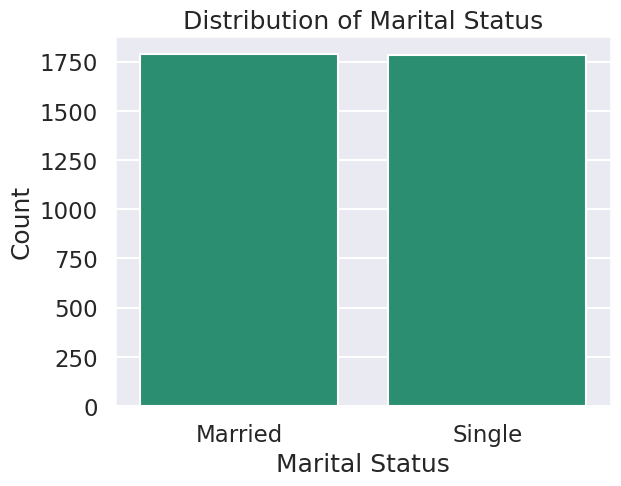

In [265]:
# Show marital status value counts and visualize them
print("Marital Status Counts:\n")
print(testdata["marital_status"].value_counts())

sns.countplot(data=testdata, x='marital_status')
plt.title("Distribution of Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.show()

Now we will convert title to gender attributes. For example, 'Mr' becomes 'M', 'Ms'/'Mrs' become 'F' and 'Mx' become 'Neutral'.

In [266]:
testdata["title"] = testdata["title"].replace({"Mr.":"M","Ms.":"F","Mrs.":"F","Mx.":"Neutral"})
testdata.rename(columns={"title":"gender"}, inplace=True) #Rename the column
testdata["gender"].unique() #To verify it's features

array(['M', 'F', 'Neutral'], dtype=object)

Gender Counts:

gender
M          1782
F          1737
Neutral      50
Name: count, dtype: int64


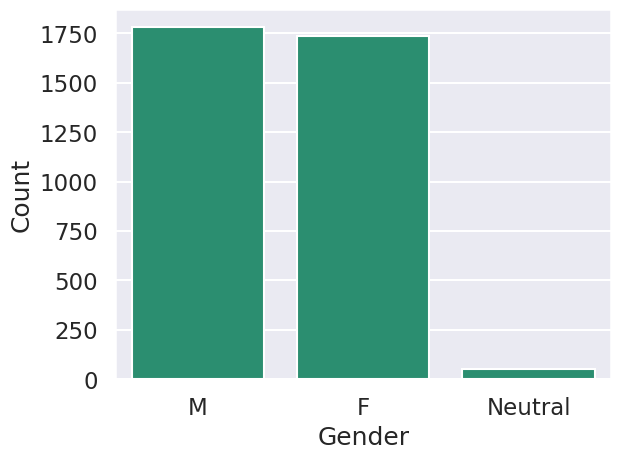

In [267]:
# Show gender value counts and visualize them
print("Gender Counts:\n")
print(testdata["gender"].value_counts())

sns.countplot(data=testdata, x='gender')
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

### Date Of Birth

Similar to title and marital column we convert date of birth to age for better usability in analysis and modeling

In [268]:
# Convert the DOB column to age and drop the date_of_birth column (assuming 01/01/2025)
testdata["date_of_birth"] = pd.to_datetime(testdata["date_of_birth"]) # First convert the testdata type from object to datetime
testdata["age"] = 2025 - testdata["date_of_birth"].dt.year

In [269]:
# Drop DOB column
testdata.drop(columns=["date_of_birth"], inplace=True)

In [270]:
testdata["age"].describe()

,age
count,3569.000000
mean,36.692911
std,11.399584
min,19.000000
25%,28.000000
50%,35.000000
75%,44.000000
max,82.000000


### City, Happiness Level & Name

So after careful examining we decided we will not be using the `name`, `city`, and `hapiness_level` columns for further analysis. These columns either contain high-cardinality values or lack meaningful patterns for modeling, so we've decided to drop them.

Name will have no use for us, city already served its purpose for mapping the countries and hapiness level only had one value which would not be usefull.

In [271]:
# Count the values for hapiness level
testdata["hapiness_level"].value_counts()

,count
hapiness_level,
medium,3569


In [272]:
testdata.drop(columns=['city', 'hapiness_level', 'name'], inplace=True)


# Remove from categorical list
for col in ['name', 'hapiness_level', 'city']:
    if col in categorical_features:
        categorical_features.remove(col)

### Education Level and Financial Wellness Index



---


Firstly, we are converting European-style decimal notation to Python-compatible float format using string replacement:

In [273]:
for col in ['education_level', 'financial_wellness_index']:
    testdata[col] = (
        testdata[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

In [274]:
testdata[['education_level', 'financial_wellness_index']].describe()

,education_level,financial_wellness_index
count,3444.000000,3480.000000
mean,6.307658,106.290513
std,2.879723,61.528586
min,0.000000,-0.050000
25%,4.112125,87.870800
50%,6.341600,99.971200
75%,8.626550,114.685500
max,13.948000,397.435000


Now we will handle missing values of both `education_level` and `financial_wellness_index` seperately in the best possible ways.

**Education Level**

First by using group-wise medians based on age, assuming educational level correlates with age.

Any remaining nulls are imputed using the global median.

In [275]:
grouped_median = testdata.groupby('age')['education_level'].median()

# Fill nulls with grouped medians
testdata['education_level'] = testdata['education_level'].fillna(
    testdata.groupby('age')['education_level'].transform('median')
)

# Fallback to global median for remaining NaNs
global_median = testdata['education_level'].median()
testdata['education_level'] = testdata['education_level'].fillna(global_median)

**Financial Wellness Index**

We convert the values from string to float, and clip all the negative values to zero.

We also fill the missing values via random sampling from the existing distribution to retain realistic variance.

In [276]:
# Replace any negative values in financial_wellness_index with 0
testdata['financial_wellness_index'] = testdata['financial_wellness_index'].clip(lower=0)

# Fill missing values with random samples to preserve the distribution and avoid unusal spikes.
def random_sample_impute(series):
    missing = series.isnull()
    n_missing = missing.sum()

    sampled = series.dropna().sample(n=n_missing, replace=True, random_state=42)
    sampled.index = series[missing].index

    return series.fillna(sampled)

testdata['financial_wellness_index'] = random_sample_impute(testdata['financial_wellness_index'])

## Numerical Features Cleaning

In this section we will go column by column taking care of nulls, outliers, skewness and other things that might need to be worked on , along with exploratory data analysis. Also, keep in mind that whenever we use a function to scale the data we create a new column with "scaled" so we can later use it for modelling. Our goal is to normalize the data and minimize the outliers, which we will check with histplots and boxplots for each column.

In [277]:
# Create a for loop to convert every numerical feature to float
for feature in numerical_features:
    testdata[feature] = (
        testdata[feature]
        .astype(str)  # Ensure it's a string first
        .str.replace(',', '.')  # Replace commas with dots
        .astype(float)
        )

In [278]:
testdata[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
financial_wellness_index,3569.0,106.457997,61.595411,0.0000,87.914800,99.97890,114.850000,397.4350
investment_portfolio_value,3498.0,12.571752,22.485214,0.0000,3.016075,8.50075,13.188700,276.9280
social_media_influence_score,3462.0,6.177793,4.403815,0.4265,3.207075,4.47105,8.118325,40.3661
investments_risk_appetite,3498.0,4.483087,2.637777,0.0000,1.957725,4.99445,6.956800,8.6631
investments_risk_tolerance,3515.0,7.529475,3.965794,1.7281,4.837700,6.24060,8.875600,32.1395
avg_monthly_entertainment_expenses,3555.0,22.449041,18.135281,0.5317,8.272450,12.17800,39.527500,158.0420
avg_weekly_exercise_hours,3569.0,0.715225,1.216190,-6.3475,0.018300,0.10440,1.057100,7.9376
stress_management_score,3462.0,3.341608,1.146003,0.3689,2.566325,3.14750,4.018100,7.9335
well_being_level,3462.0,4.794921,1.902688,1.1038,3.483500,4.40150,5.623425,14.4668
environmental_awareness_rating,3444.0,0.828097,0.644145,0.0862,0.542750,0.62905,0.778275,6.9760


We will start with understanding the relationship of numerical features with each other so we can choose how to deal with them.

### Environmental Awareness Rating

In [279]:
testdata['environmental_awareness_rating'].isnull().sum()

np.int64(125)

In [280]:
#Fix null values
environmental_awareness_rating_median = testdata['environmental_awareness_rating'].median()

testdata['environmental_awareness_rating'] = testdata['environmental_awareness_rating'].fillna(environmental_awareness_rating_median)

In [281]:
#Log transform to scale (log1p handles 0 safely)
testdata['environmental_awareness_rating_scaled'] = np.log1p(testdata['environmental_awareness_rating'])

We decided to use the log-transform to reduce right skew and handle extreme values because log1p handles 0s safely

In [282]:
#Scale using RobustScaler
testdata['environmental_awareness_rating_scaled'] = env_scaler.transform(testdata[['environmental_awareness_rating_scaled']])

### Health Consciousness Rating

In [283]:
testdata['health_consciousness_rating'].isnull().sum()

np.int64(71)

In [284]:
#Fill nulls with grouped medians
health_consciousness_rating_median = testdata.groupby('well_being_level')['health_consciousness_rating'].transform('median')

testdata['health_consciousness_rating'] = testdata['health_consciousness_rating'].fillna(health_consciousness_rating_median)

#Fallback to global median for remaining NaNs
health_consciousness_rating_global_median = testdata['health_consciousness_rating'].median()
testdata['health_consciousness_rating'] = testdata['health_consciousness_rating'].fillna(health_consciousness_rating_global_median)


In [285]:
#Log transform (log1p handles 0 safely)
testdata['health_consciousness_rating_scaled'] = np.log1p(testdata['health_consciousness_rating'])

In [286]:
#Scale using RobustScaler
testdata['health_consciousness_rating_scaled'] = health_scaler.transform(testdata[['health_consciousness_rating_scaled']])

### Avg Monthly Entertainment Expenses

MISSING VALUES

In [287]:
#check for missing values
testdata['avg_monthly_entertainment_expenses'].isnull().sum()

np.int64(14)

In [288]:
#Fill nulls with grouped medians
avg_monthly_entertainment_expenses_median = testdata.groupby('stress_management_score')['avg_monthly_entertainment_expenses'].transform('median')

testdata['avg_monthly_entertainment_expenses'] = testdata['avg_monthly_entertainment_expenses'].fillna(avg_monthly_entertainment_expenses_median)

#Fallback to global median for remaining NaNs
avg_monthly_entertainment_expenses_global_median = testdata['avg_monthly_entertainment_expenses'].median()
testdata['avg_monthly_entertainment_expenses'] = testdata['avg_monthly_entertainment_expenses'].fillna(avg_monthly_entertainment_expenses_global_median)

### Avg Weekly Exercise Hours

In [289]:
#check nulls
testdata['avg_weekly_exercise_hours'].isnull().sum()

np.int64(0)

In [290]:
#Fill nulls with median value (best for skewed data)
avg_weekly_exercise_hours_median = testdata['avg_weekly_exercise_hours'].median()

testdata['avg_weekly_exercise_hours'] = testdata['avg_weekly_exercise_hours'].fillna(avg_weekly_exercise_hours_median)

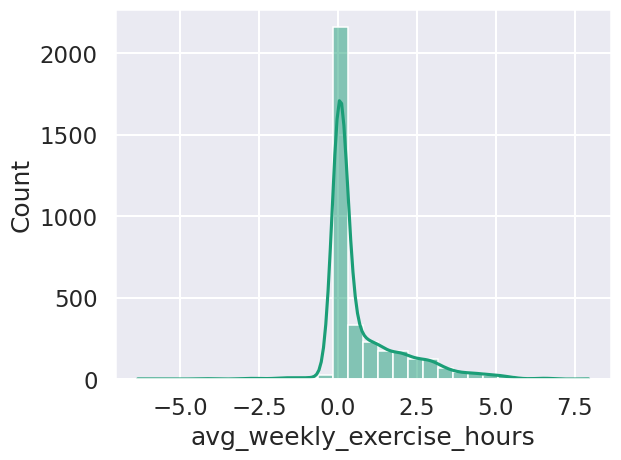

In [291]:
sns.histplot(testdata['avg_weekly_exercise_hours'], bins=30, kde=True)
plt.show()

We notice that we have negative hours for a varaible that shoult had negative values, so we decide do cap the lower bound to 0 since its the minimal possible value.

In [292]:
#lower bound to 0
testdata['avg_weekly_exercise_hours'] = testdata['avg_weekly_exercise_hours'].clip(lower=0)

In [293]:
# Log transformation (add 1 to handle zeros)
testdata['avg_weekly_exercise_hours_scaled'] = np.log1p(testdata['avg_weekly_exercise_hours'])

### Stress Management Score

In [294]:
testdata["stress_management_score"].isnull().sum()

np.int64(107)

The highest correlations we had on all the columns was 0.75 between stress management score and well being level, so we will use it to fill the nulls

In [295]:
#highest correlation is with well being level, 0.75
#Fill nulls with grouped medians
stress_management_score_median = testdata.groupby('well_being_level')['stress_management_score'].transform('median')
testdata['stress_management_score'] = testdata['stress_management_score'].fillna(stress_management_score_median)

#Fallback to global median for remaining NaNs
stress_management_score_median_global_median = testdata['stress_management_score'].median()
testdata['stress_management_score'] = testdata['stress_management_score'].fillna(global_median)

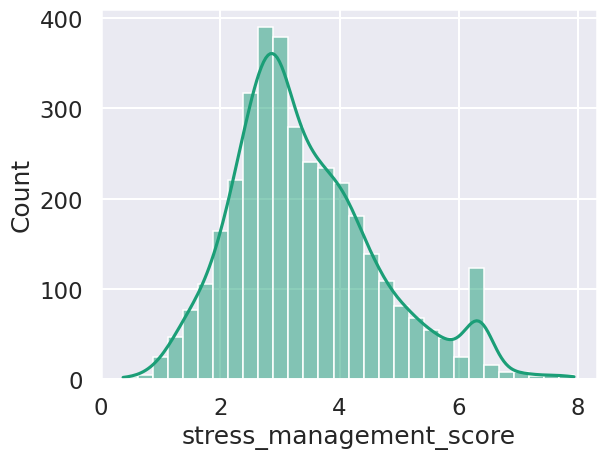

In [296]:
sns.histplot(testdata['stress_management_score'], bins=30, kde=True)
plt.show()

### Eco Consciousness Score (Dropped)

In [297]:
#drop column
testdata.drop('eco_consciousness_score', axis=1, inplace=True)

### Well Being Level

In [298]:
testdata["well_being_level"].isnull().sum()

np.int64(107)

We decided to use the KNN imputer to fill in the missing values for `well_being_level` using `stress_management_score` and `health_consciousness_rating`, since these features are related (0.75 and 0.67) and can help estimate the missing values more accurately.

In [299]:
#use the knn inputer to fill the missing values with the stress_managemnet_score and health_consciousness_rating
cols = ['well_being_level', 'stress_management_score', 'health_consciousness_rating']

In [300]:
#define and fit the model
imputer = KNNImputer(n_neighbors=5).fit(testdata[cols])

In [301]:
#transform
imputed_array = imputer.transform(testdata[cols])

In [302]:
#Update only 'well_being_level' (first column of result)
testdata['well_being_level'] = imputed_array[:, 0]

### Last Year Charity Donations (Dropped)

In [303]:
#drop the column
testdata.drop('last_year_charity_donations', axis=1, inplace=True)


Like the eco consciousness score, we decided that this column is also not useful for our analysis as it was very skewed, so we decided to drop it.

### Investment Portfolio Value

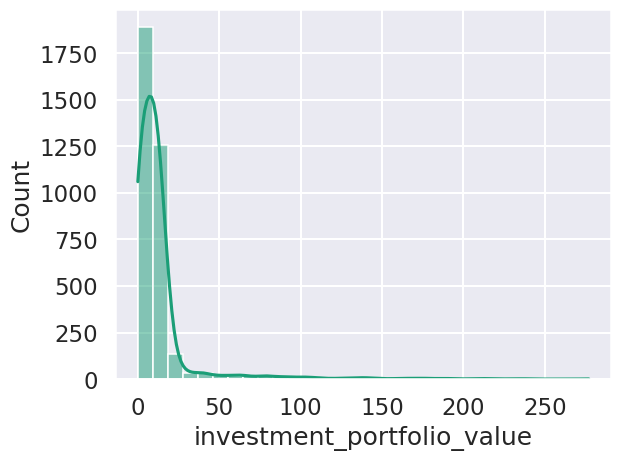

In [304]:
#graph
sns.histplot(testdata['investment_portfolio_value'], bins=30, kde=True)
plt.show()

In [305]:
testdata["investment_portfolio_value"].isnull().sum()

np.int64(71)

In [306]:
investment_portfolio_value_median = testdata.groupby('country')['investment_portfolio_value'].transform('median')
testdata['investment_portfolio_value'] = testdata['investment_portfolio_value'].fillna(investment_portfolio_value_median)

#Fallback to global median for remaining NaNs
investment_portfolio_value_global_median = testdata['investment_portfolio_value'].median()
testdata['investment_portfolio_value'] = testdata['investment_portfolio_value'].fillna(investment_portfolio_value_global_median)

In [307]:
testdata['investment_portfolio_value_scaled'] = np.log1p(testdata['investment_portfolio_value'])

### Social Media Influence Score

In [308]:
testdata["social_media_influence_score"].isnull().sum()

np.int64(107)

In [309]:
#fill the missing values with median
social_media_influence_score_median = testdata.groupby('country')['social_media_influence_score'].transform('median')
testdata['social_media_influence_score'] = testdata['social_media_influence_score'].fillna(social_media_influence_score_median)


In [310]:
#using the log scaler
testdata['social_media_influence_score_scaled'] = np.log1p(testdata['social_media_influence_score'])

### Investment Risk Appetite

In [311]:
testdata["investments_risk_appetite"].isnull().sum()

np.int64(71)

In [312]:
#Fill nulls with grouped medians from the column with highest correlation

investments_risk_appetite_median = testdata.groupby('investments_risk_tolerance')['investments_risk_appetite'].transform('median')
testdata['investments_risk_appetite'] = testdata['investments_risk_appetite'].fillna(investments_risk_appetite_median)

#Fallback to global median for remaining NaNs
investments_risk_appetite_global_median = testdata['investments_risk_appetite'].median()
testdata['investments_risk_appetite'] = testdata['investments_risk_appetite'].fillna(investments_risk_appetite_global_median)

### Investment Risk Tolerance

In [313]:
testdata["investments_risk_tolerance"].isnull().sum()

np.int64(54)

In [314]:
#Fill nulls with grouped medians

investments_risk_tolerance_median = testdata.groupby('investments_risk_appetite')['investments_risk_tolerance'].transform('median')
testdata['investments_risk_tolerance'] = testdata['investments_risk_tolerance'].fillna(investments_risk_tolerance_median)

#Fallback to global median for remaining NaNs
investments_risk_tolerance_global_median = testdata['investments_risk_tolerance'].median()
testdata['investments_risk_tolerance'] = testdata['investments_risk_tolerance'].fillna(investments_risk_tolerance_global_median)

In [315]:
# Scale it using log
testdata['investments_risk_tolerance_scaled'] = np.log1p(testdata['investments_risk_tolerance'])

## Create dummy variables

To prepare categorical variables for machine learning algorithms, we converted the selected columns (`continent`, `marital_status`, and `gender`) into dummy variables. This transformation allows algorithms to process non-numeric features by representing each category as a separate binary column.

In [316]:
categorical_cols= testdata[['continent', 'marital_status', 'gender']]

In [317]:
testdata = pd.get_dummies(testdata, columns=categorical_cols.columns) #Added dtype='object'

In [318]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3569 entries, 0 to 3568
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   citizen_id                             3569 non-null   int64  
 1   avg_monthly_entertainment_expenses     3569 non-null   float64
 2   avg_weekly_exercise_hours              3569 non-null   float64
 3   country                                3569 non-null   object 
 4   education_level                        3569 non-null   float64
 5   environmental_awareness_rating         3569 non-null   float64
 6   financial_wellness_index               3569 non-null   float64
 7   health_consciousness_rating            3569 non-null   float64
 8   investment_portfolio_value             3569 non-null   float64
 9   investments_risk_appetite              3569 non-null   float64
 10  investments_risk_tolerance             3569 non-null   float64
 11  soci

In [319]:
testdata_cleaned= testdata.copy()

We dropped redundant reference categories (e.g., `continent_Unknown`, `gender_Neutral`) to avoid the dummy variable trap and multicollinearity issues.

In [320]:
columns_to_drop = [
    'citizen_id',
    'country',
    'education_category',
    'environmental_awareness_rating',
    'health_consciousness_rating',
    'avg_weekly_exercise_hours',
    'investment_portfolio_value',
    'investments_risk_tolerance',
    'social_media_influence_score',
    'continent_Unknown',  # to avoid dummy variable trap
    'education_category',
    'gender_Neutral',
    "financial_wellness_category"
]

testdata_cleaned = testdata.drop(columns=columns_to_drop, errors='ignore')

In [321]:
testdata_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3569 entries, 0 to 3568
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   avg_monthly_entertainment_expenses     3569 non-null   float64
 1   education_level                        3569 non-null   float64
 2   financial_wellness_index               3569 non-null   float64
 3   investments_risk_appetite              3569 non-null   float64
 4   stress_management_score                3569 non-null   float64
 5   well_being_level                       3569 non-null   float64
 6   age                                    3569 non-null   int32  
 7   environmental_awareness_rating_scaled  3569 non-null   float64
 8   health_consciousness_rating_scaled     3569 non-null   float64
 9   avg_weekly_exercise_hours_scaled       3569 non-null   float64
 10  investment_portfolio_value_scaled      3569 non-null   float64
 11  soci

## Selecting most important features for the model

In this step, we cleaned the dataset by dropping unused, redundant, or raw versions of already-scaled variables. Features such as `citizen_id`, raw continuous variables, and previously encoded categorical labels were removed.

We then used ANOVA F-score (via `SelectKBest`) to statistically assess and rank each feature’s importance in predicting the target variable `lifestyle`. The most discriminative features were retained based on their F-score, ensuring that only highly relevant predictors remained in the final dataset.

Drop the columns with F score bellow 16

In [322]:
columns_to_drop = ["financial_wellness_index",
                   "age",
                   "marital_status_Single",
                   "marital_status_Married",
                   "continent_South America",
                   "continent_Europe",
                   "continent_Asia",
                   "continent_North America",
                   "gender_F",
                   "gender_M",
                   "continent_Oceania",
                   "education_level",
                   "avg_monthly_entertainment_expenses",
                   "environmental_awareness_rating_scaled"
]

testdata_cleaned = testdata_cleaned.drop(columns=columns_to_drop, errors='ignore')

## Scale the data

After training and validating our models, we prepared the **unseen test data** for final prediction. Using the previously fitted `MinMaxScaler` from the training phase, we scaled the test set to match the feature space expected by the model:

In [323]:
# Transform test data using the training scaler
minmax_testdata = minmax_scaler.transform(testdata_cleaned)

# Kaggle

The final model we chose was the **GradientBoostingClassifier** based on the scores from before, here we are defining it:

In [324]:
finalmodel =GradientBoostingClassifier(learning_rate= 0.05, max_depth= 3, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 70, subsample= 0.9)
# Fit the model with features and target variable
finalmodel.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=70, subsample=0.9)

In [325]:
# Making the predictions
y_test_pred = finalmodel.predict(minmax_testdata)

In [326]:
#count how many rows
print(len(y_test_pred))

3569


In [327]:
y_test_pred = pd.Series(y_test_pred)
y_test_pred.value_counts()

,count
Investor,1255
Fitness Enthusiast,1228
Health-Conscious,1086


We stored the predictions alongside the `citizen_id` values and exported them to a CSV file named `submission.csv` to load into Kaggle.

In [328]:
# Create a DataFrame with IDs and predictions
submission_df = pd.DataFrame({
    'citizen_id': testdata['citizen_id'],  # Replace with actual ID column name
    'lifestyle': y_test_pred
})

In [329]:
submission_df.to_csv('submission.csv', index=False)  # No row numbers

In [330]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Action Plan & Critical Insight

**KEY INSIGHTS**

Through comprehensive exploratory, descriptive, and predictive modeling phases, this project revealed three distinct lifestyle profiles across a globally diverse population:

  * **Health-Conscious**: Individuals prioritizing wellness, moderate spending, and health-oriented habits.

  * **Investor**: Citizens characterized by higher financial literacy and risk engagement, but more moderate well-being and health awareness.

  * **Fitness Enthusiast**: A cluster driven by frequent exercise and digital presence, often with strong social media influence scores.

These profiles were discovered through unsupervised learning and successfully predicted with high performance using a Gradient Boosting Classifier, trained on key behavioral and socio-economic features such as exercise frequency, well-being, health consciousness, and stress management ability.

Our modeling pipeline achieved strong predictive accuracy and balanced class detection, with minimal bias toward overrepresented lifestyle categories.

**IMPLICATIONS FOR WHO**

The lifestyle segmentation model developed here can inform WHO’s efforts in:

  * **Targeted Health Interventions**: Deploying differentiated messaging and resources tailored to each lifestyle segment (e.g., stress-focused interventions for "Investors", preventative care for "Fitness Enthusiasts").

  * **Personalized Public Health Strategies**: Segment-based program design to promote preventive behaviors, e.g., combining financial wellness with health education for overlapping segments.

  * **Resource Optimization**: Allocating wellness, education, or campaign resources based on the predicted prevalence of each lifestyle group in different regions or demographics.

  * **Monitoring Behavioral Shifts**: Using future iterations of this model to monitor lifestyle transitions, especially in response to crises or policy changes.

Based on the results of our clustering and predictive modeling, we propose the following actions for the WHO-LIFE team:

1. **Profile-Driven Policy Design**

Use the lifestyle clusters — particularly the combined health-financial profile — to shape more holistic policies that promote physical wellness, financial literacy, and balanced digital habits.

2. **Targeted Public Health Campaigns**

Leverage model predictions to identify groups at risk (e.g., low activity + high digital engagement) and design customized interventions such as digital wellness education or incentivized fitness programs.

3. **Country-Level Program Adaptation**

Integrate macro-level data (GDP, population) with behavior patterns to tailor national campaigns. For instance, focus on improving physical engagement in high-income countries with low activity levels.

4. **Predictive Monitoring**

Apply the trained model to new population data to track emerging lifestyle shifts, enabling early intervention in communities showing signs of declining well-being or increasing risk.

5. **Collaboration and Scalability**

Share this modeling framework with local governments and NGOs to support data-driven collaboration and scale lifestyle prediction efforts globally.

# Conclusion

This project affirms that leveraging machine learning for lifestyle classification can provide WHO with a scalable, data-driven foundation for global health strategy design. By segmenting citizens not only demographically but behaviorally, WHO can move toward more **precision public health**
, making interventions smarter, more timely, and more effective.